# Data Preprocessing (Imputation, create at least 2 new features)

#### Import the required liberaries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import opendatasets as od
from pathlib import Path

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from operator import itemgetter

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression

import xgboost
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

#### Load the dataset for training and testing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Data Cleaning

In [3]:
def find_missing_percent(data):
    
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val / data.shape[0]) * 100, 2)
        miss_df = miss_df.append(dict(zip(miss_df.columns, [col, sum_miss_val, percent_miss_val])), ignore_index=True)
    return miss_df

In [4]:
miss_df = find_missing_percent(train)

'''Displays columns with missing values'''

display(miss_df[miss_df['PercentMissing'] > 0.0])

print("\n")

print(f"Number of columns with missing values:{str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")

,ColumnName,TotalMissingVals,PercentMissing
3,LotFrontage,259.0,17.74
6,Alley,1369.0,93.77
25,MasVnrType,8.0,0.55
26,MasVnrArea,8.0,0.55
30,BsmtQual,37.0,2.53
31,BsmtCond,37.0,2.53
32,BsmtExposure,38.0,2.60
33,BsmtFinType1,37.0,2.53
35,BsmtFinType2,38.0,2.60
42,Electrical,1.0,0.07




Number of columns with missing values:19


##### Drop the columns which have more than 70% of missing values

In [5]:
drop_cols = miss_df[miss_df['PercentMissing'] >70.0].ColumnName.tolist()

print(f"Number of columns with more than 70%: {len(drop_cols)}")

train = train.drop(drop_cols,axis=1)
test = test.drop(drop_cols,axis =1)

miss_df = miss_df[miss_df['ColumnName'].isin(train.columns)]

'''Columns to Impute'''

impute_cols = miss_df[miss_df['TotalMissingVals']>0.0].ColumnName.tolist()
miss_df[miss_df['TotalMissingVals']>0.0]

Number of columns with more than 70%: 4


,ColumnName,TotalMissingVals,PercentMissing
3,LotFrontage,259.0,17.74
25,MasVnrType,8.0,0.55
26,MasVnrArea,8.0,0.55
30,BsmtQual,37.0,2.53
31,BsmtCond,37.0,2.53
32,BsmtExposure,38.0,2.60
33,BsmtFinType1,37.0,2.53
35,BsmtFinType2,38.0,2.60
42,Electrical,1.0,0.07
57,FireplaceQu,690.0,47.26


In [6]:
'''Segregate the numeric and categoric data'''

numeric_cols = train.select_dtypes(['float','int']).columns
categoric_cols = train.select_dtypes('object').columns

train_numeric = train[numeric_cols[:-1]]
train_categoric = train[categoric_cols]

test_numeric = test[numeric_cols[:-1]]
test_categoric = test[categoric_cols]

nominal_cols = ['MSZoning', 'Street','LandContour','Neighborhood','Condition1','Condition2',
                'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                'Heating','GarageType','SaleType','SaleCondition']

ordinal_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
                'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','LotShape',
                'Utilities','LandSlope','BldgType','HouseStyle','LotConfig']

#### MICE (Multiple Imputation by Chained Equation)

In [7]:
def mice_imputation_numeric(train_numeric, test_numeric):
    
    """
    Impute numeric data using MICE imputation with Gradient Boosting Regressor.
    """
    
    iter_imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed_train = iter_imp_numeric.fit_transform(train_numeric)
    imputed_test = iter_imp_numeric.transform(test_numeric)
    train_numeric_imp = pd.DataFrame(imputed_train, columns = train_numeric.columns, index= train_numeric.index)
    test_numeric_imp = pd.DataFrame(imputed_test, columns = test_numeric.columns, index = test_numeric.index)
    return train_numeric_imp, test_numeric_imp

def mice_imputation_categoric(train_categoric, test_categoric):
    
    """
    Impute categoric data using MICE imputation with Gradient Boosting Classifier.
    Steps:
    1. Ordinal Encode the non-null values
    2. Use MICE imputation with Gradient Boosting Classifier to impute the ordinal encoded data
    3. Inverse transform the ordinal encoded data.
    """
    
    ordinal_dict={}
    
    for col in train_categoric:
        
        '''Ordinal encode train data'''
        
        ordinal_dict[col] = OrdinalEncoder()
        nn_vals = np.array(train_categoric[col][train_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].fit_transform(nn_vals)).reshape(-1,)
        train_categoric[col].loc[train_categoric[col].notnull()] = nn_vals_arr

    for col in test_categoric:
        
        '''Ordinal encode test data'''
        
        nn_vals = np.array(test_categoric[col][test_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].transform(nn_vals)).reshape(-1,)
        test_categoric[col].loc[test_categoric[col].notnull()] = nn_vals_arr
    
    '''Impute the data using MICE with Gradient Boosting Classifier'''
    
    iter_imp_categoric = IterativeImputer(GradientBoostingClassifier(), max_iter =5, initial_strategy='most_frequent')
    imputed_train = iter_imp_categoric.fit_transform(train_categoric)
    imputed_test = iter_imp_categoric.transform(test_categoric)
    train_categoric_imp = pd.DataFrame(imputed_train, columns =train_categoric.columns,index = train_categoric.index).astype(int)
    test_categoric_imp = pd.DataFrame(imputed_test, columns=test_categoric.columns,index =test_categoric.index).astype(int)
    
    '''Inverse Transform'''
    
    for col in train_categoric_imp.columns:
        oe = ordinal_dict[col]
        train_arr= np.array(train_categoric_imp[col]).reshape(-1,1)
        test_arr = np.array(test_categoric_imp[col]).reshape(-1,1)
        train_categoric_imp[col] = oe.inverse_transform(train_arr)
        test_categoric_imp[col] = oe.inverse_transform(test_arr)

    return train_categoric_imp, test_categoric_imp


In [8]:
train_numeric_imp, test_numeric_imp = mice_imputation_numeric(train_numeric,test_numeric)
train_categoric_imp, test_categoric_imp = mice_imputation_categoric(train_categoric, test_categoric)

'''Concatenate Numeric and Categoric Training and Test set data '''

train = pd.concat([train_numeric_imp, train_categoric_imp, train['SalePrice']], axis = 1)
test = pd.concat([test_numeric_imp, test_categoric_imp], axis =1)

## Data Visualization

In [9]:
def plot_histogram(train, col1, col2, cols_list, last_one =False):
    
    """
    Plot the histogram for the numerical columns. The bin width
    is calculated by Freedman Diaconis Rule and Sturges rule.
    
    """
    
    if(col1 in cols_list):
        freq1, bin_edges1 = np.histogram(train[col1],bins='sturges')
    else:
        freq1, bin_edges1 = np.histogram(train[col1],bins='fd')
    if(col2 in cols_list):
        freq2, bin_edges2 = np.histogram(train[col2],bins='sturges')
    else:
        freq2, bin_edges2 = np.histogram(train[col2],bins='fd')
        
    if(last_one!=True):
        plt.figure(figsize=(45,18))  
        ax1 = plt.subplot(1,2,1)
        ax1.set_title(col1,fontsize=45)
        ax1.set_xlabel(col1,fontsize=40)
        ax1.set_ylabel('Frequency',fontsize=40)
        train[col1].hist(bins=bin_edges1,ax = ax1, xlabelsize=30, ylabelsize=30)
        
    else:
        plt.figure(figsize=(20,10))
        ax1 = plt.subplot(1,2,1)
        ax1.set_title(col1,fontsize=25)
        ax1.set_xlabel(col1,fontsize=20)
        ax1.set_ylabel('Frequency',fontsize=20)
        train[col1].hist(bins=bin_edges1,ax = ax1, xlabelsize=15, ylabelsize=15)
    
    if(last_one != True):
        ax2 = plt.subplot(1,2,2)
        ax2.set_title(col2,fontsize=45)
        ax2.set_xlabel(col2,fontsize=40)
        ax2.set_ylabel('Frequency',fontsize=40)
        train[col2].hist(bins=bin_edges2, ax = ax2, xlabelsize=30, ylabelsize=30)

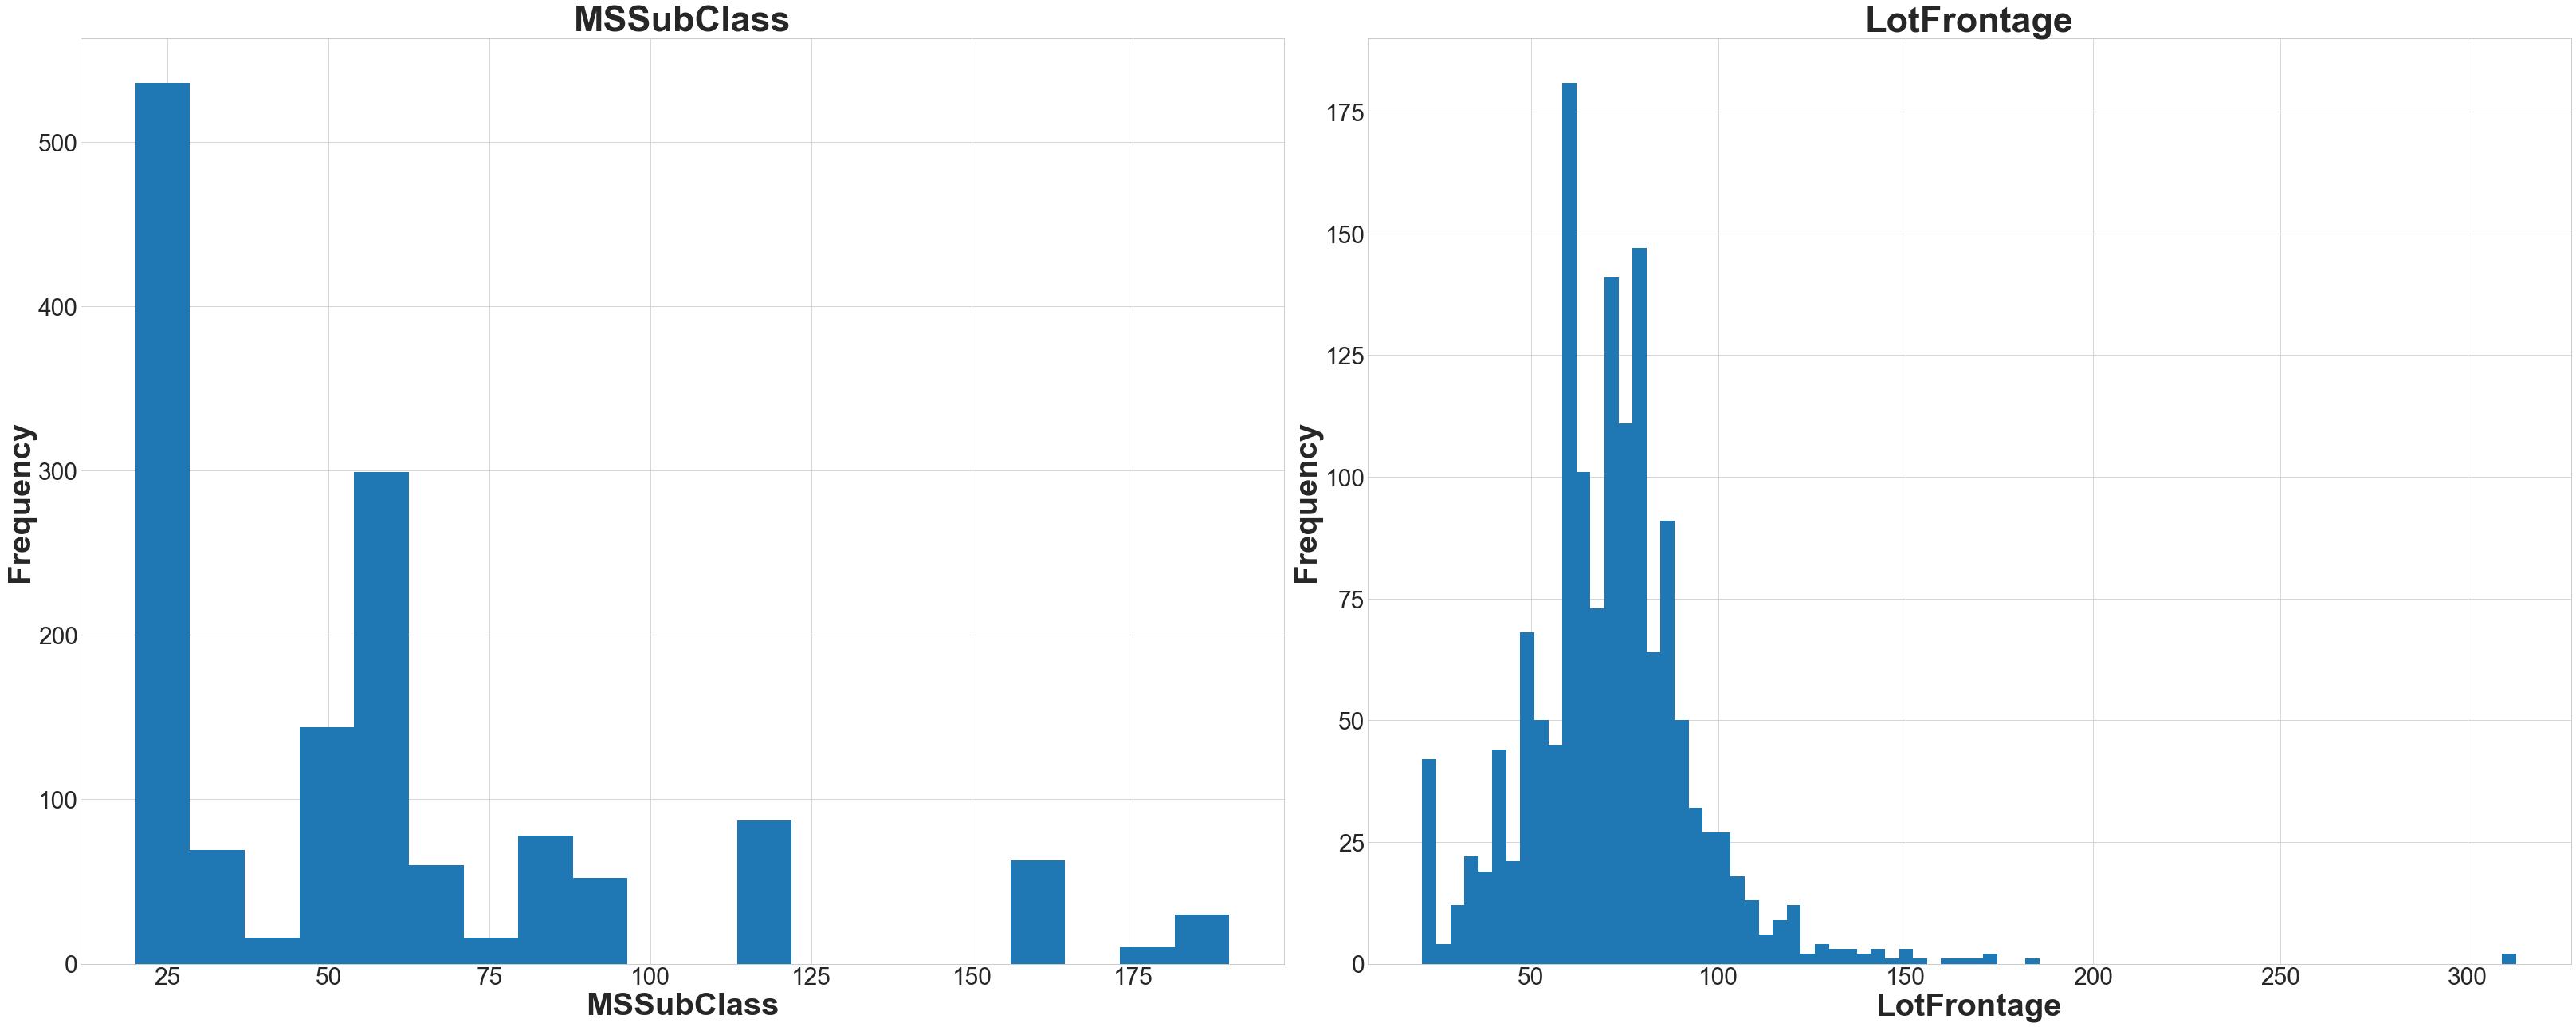

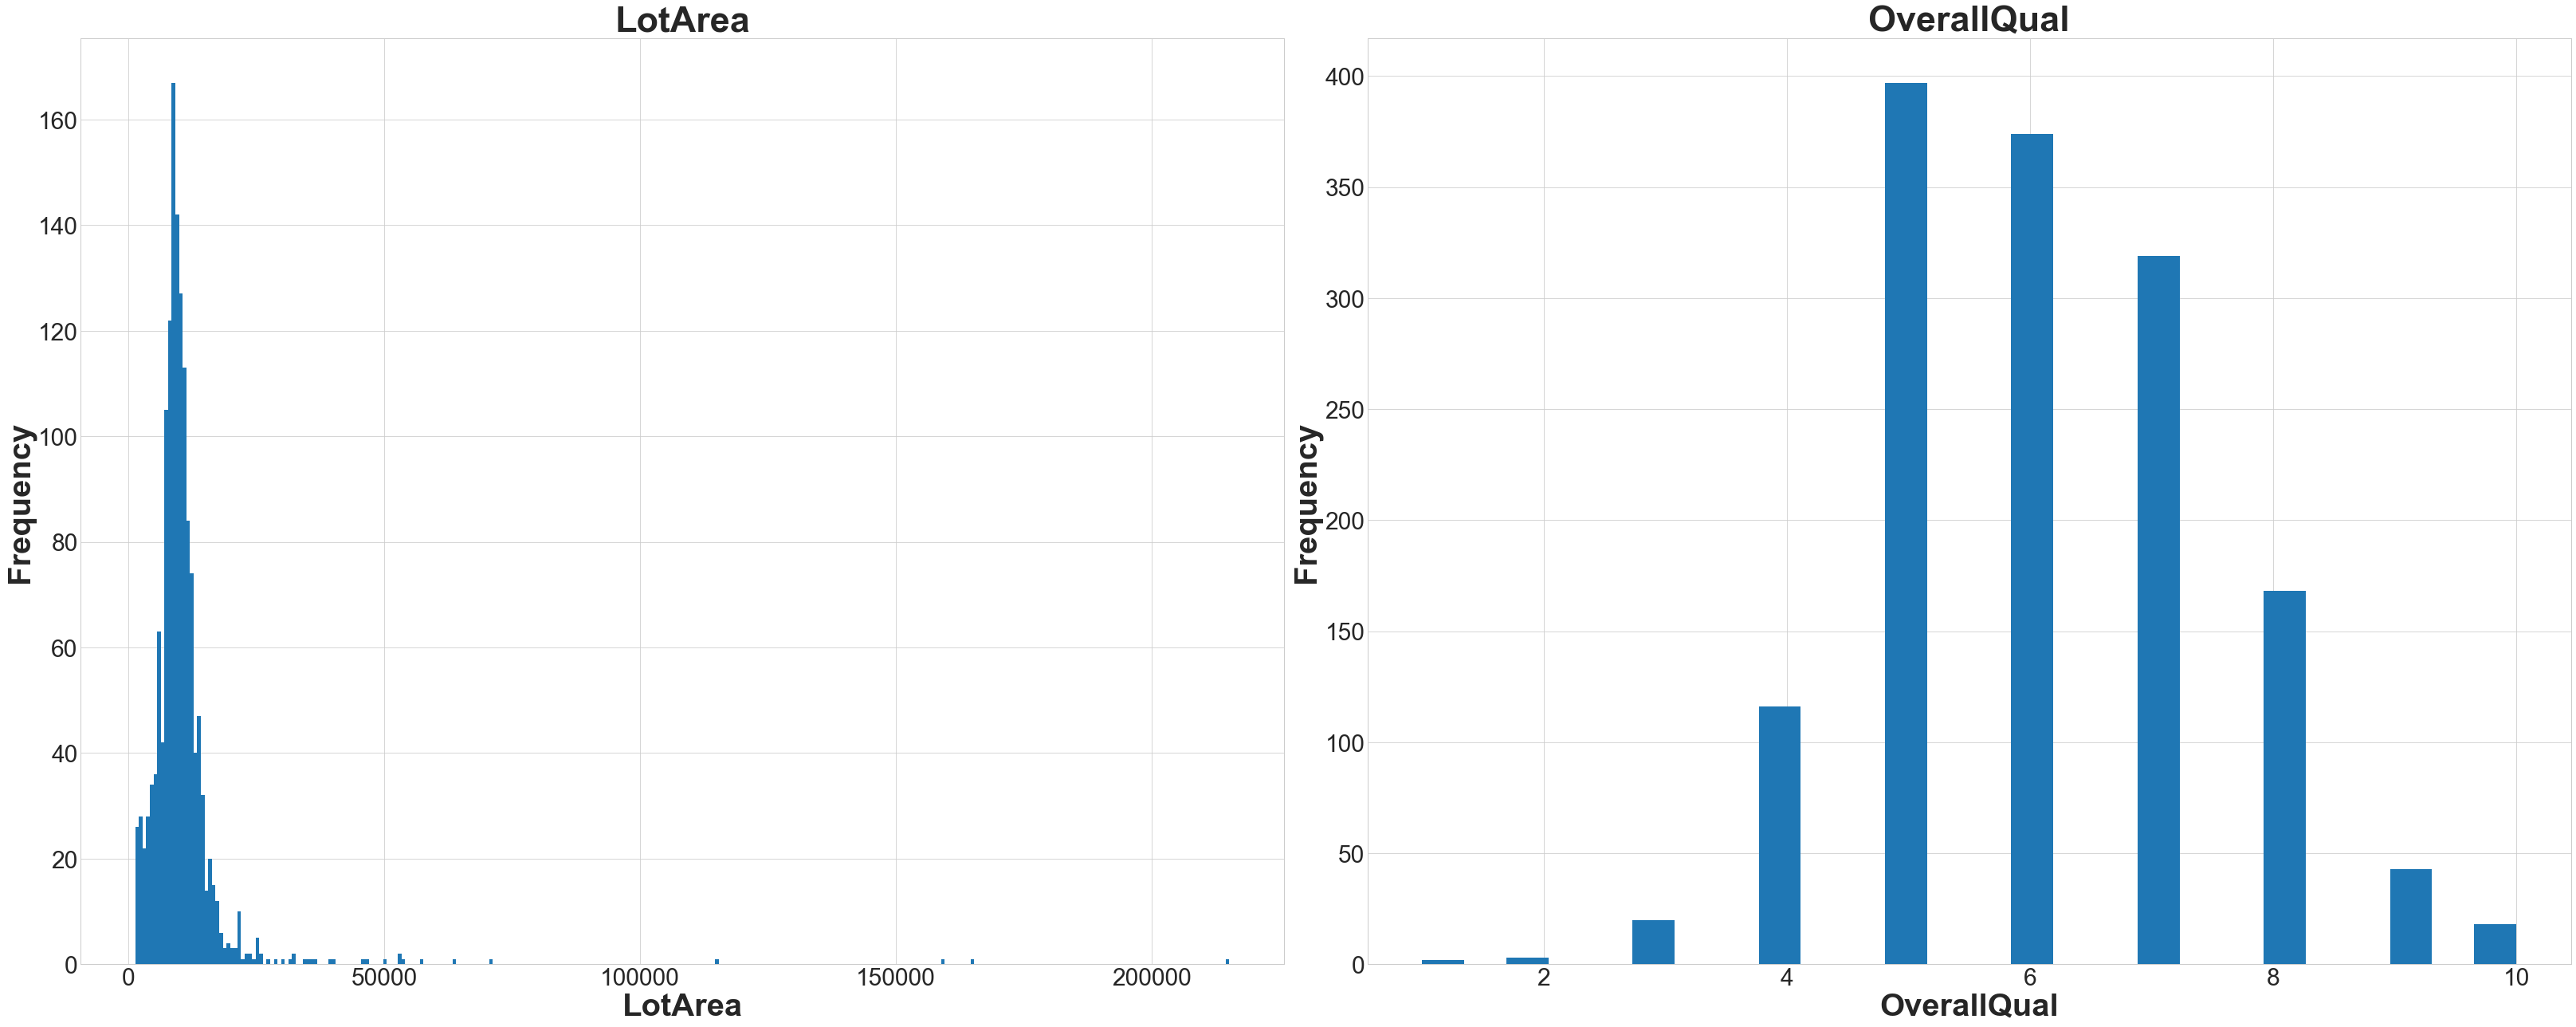

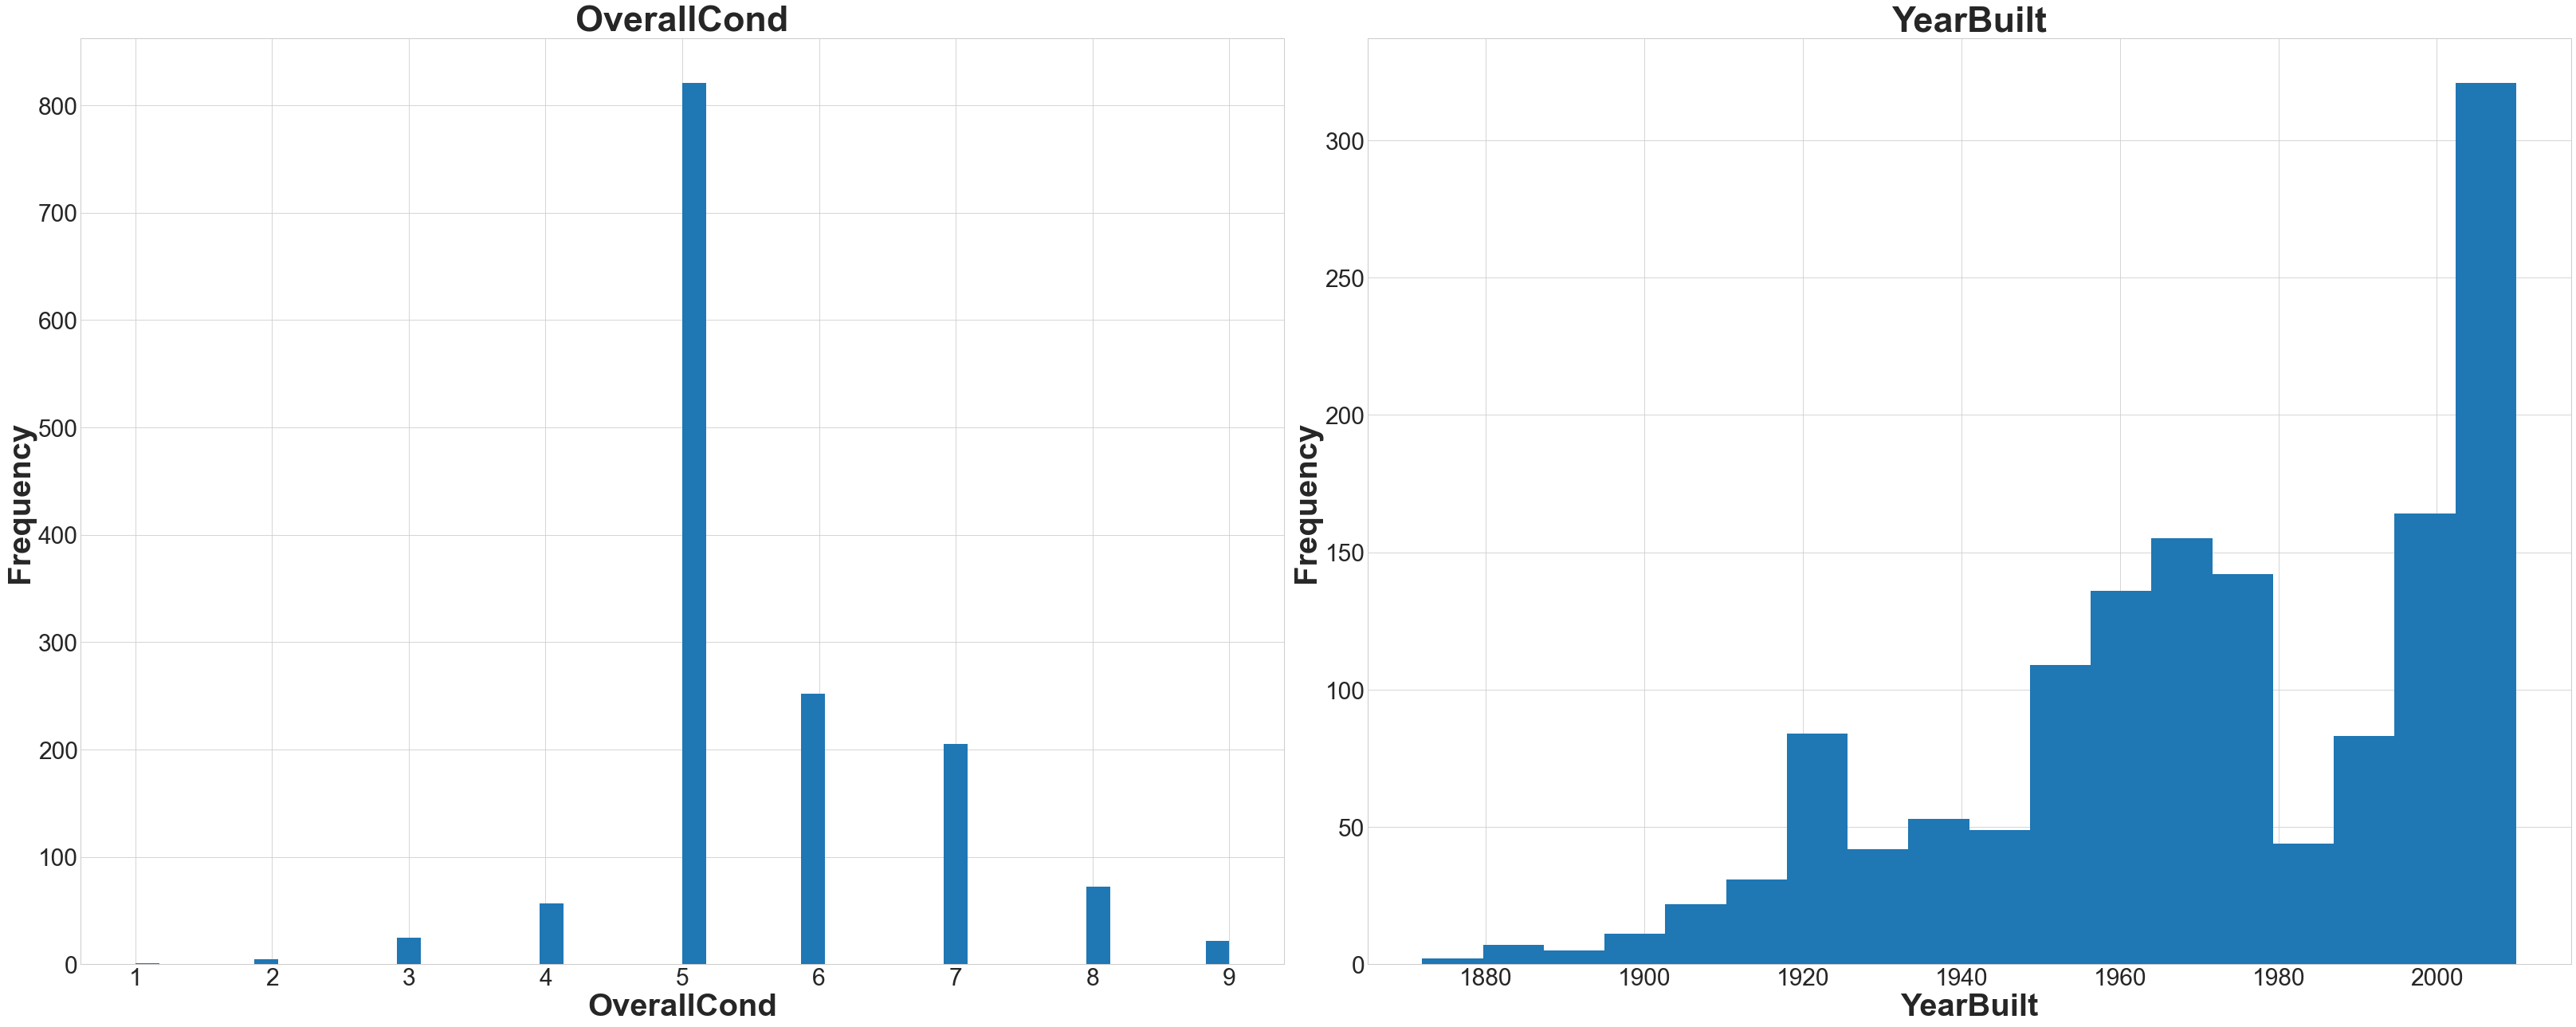

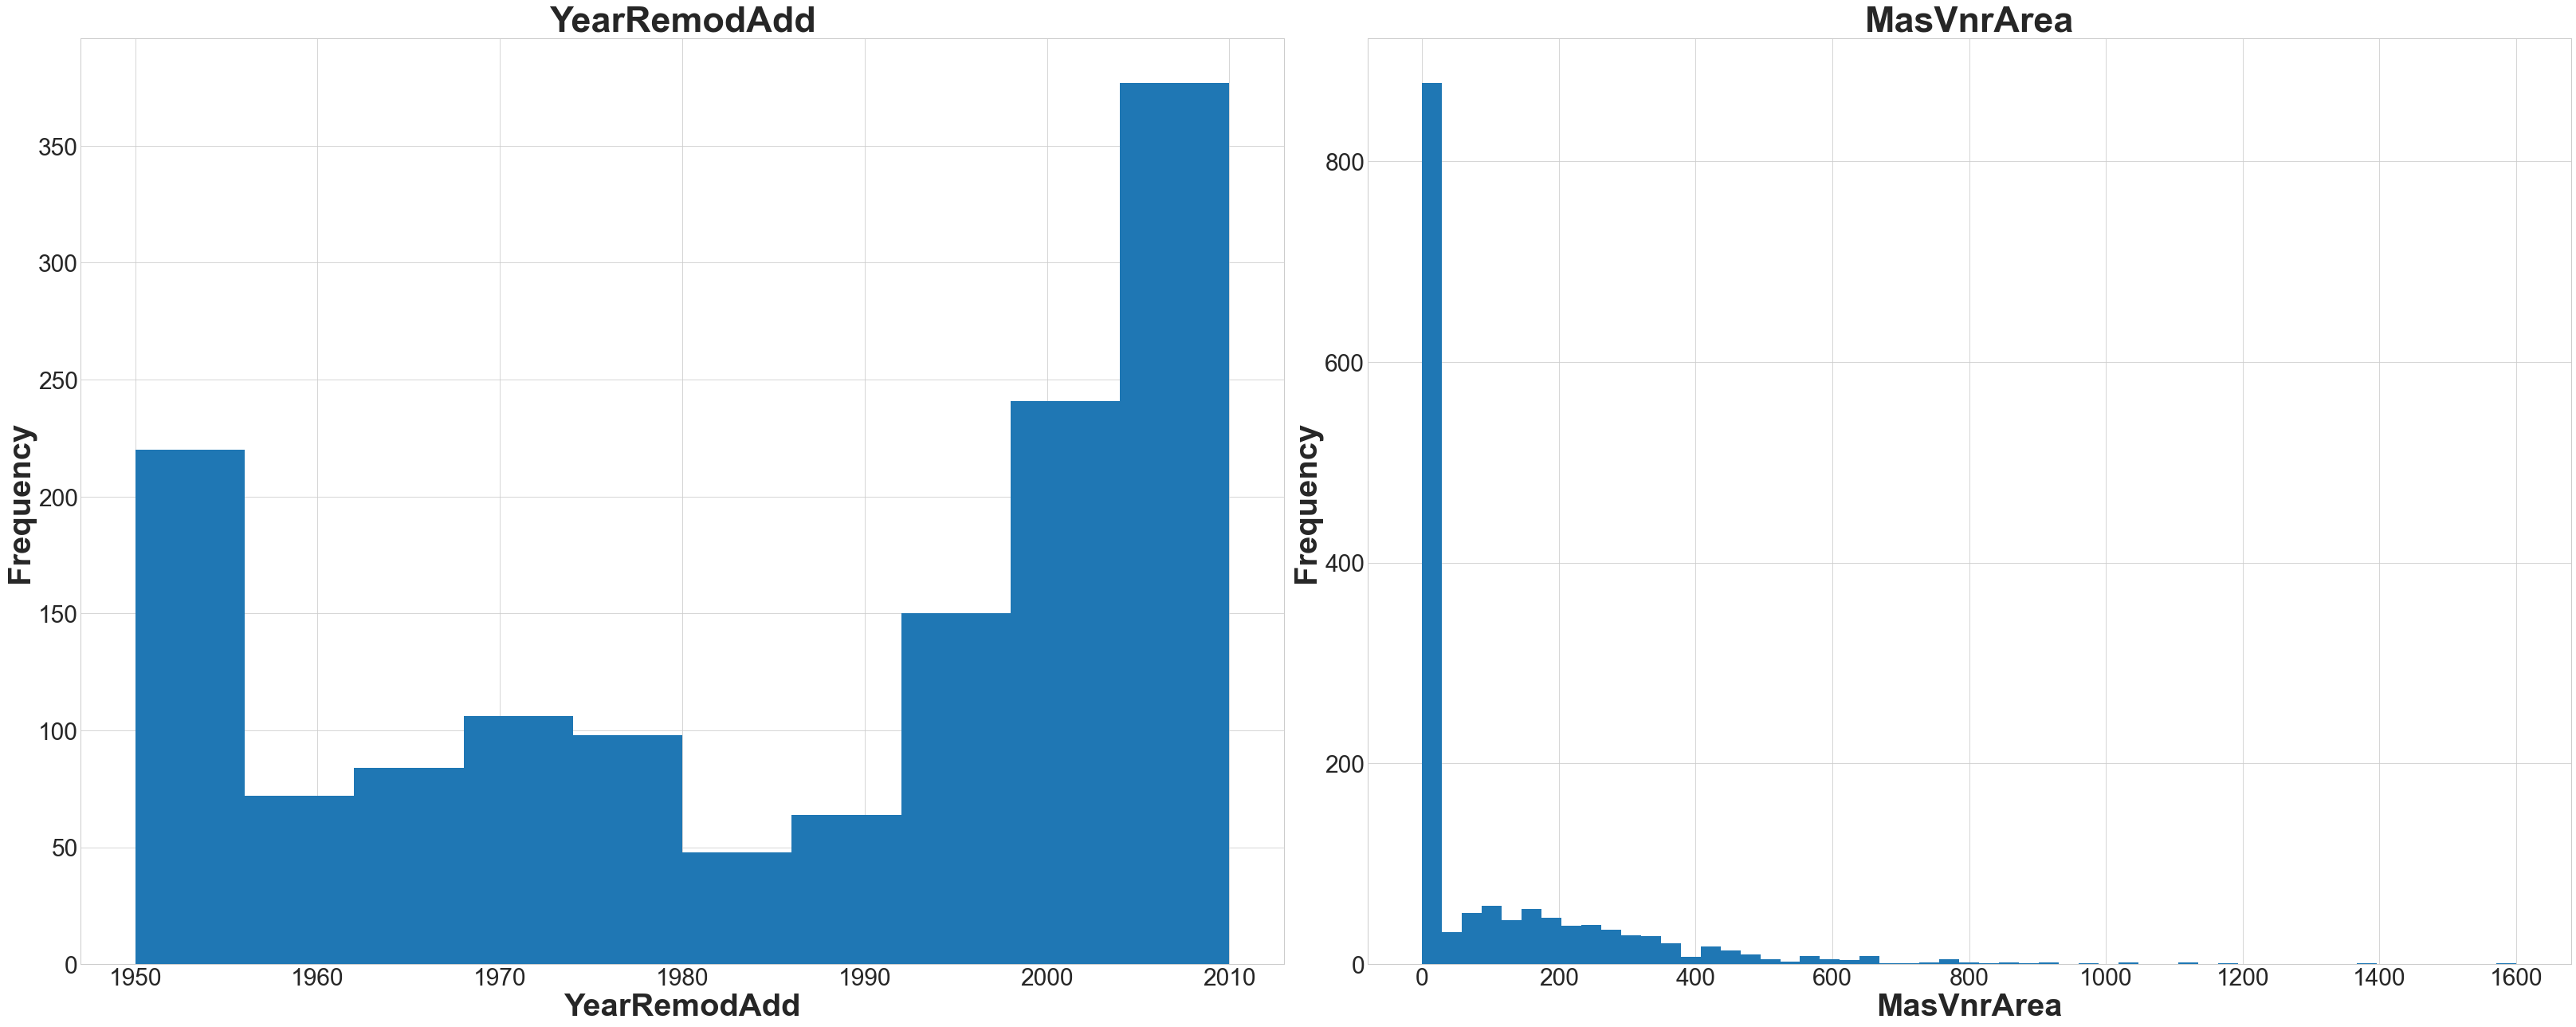

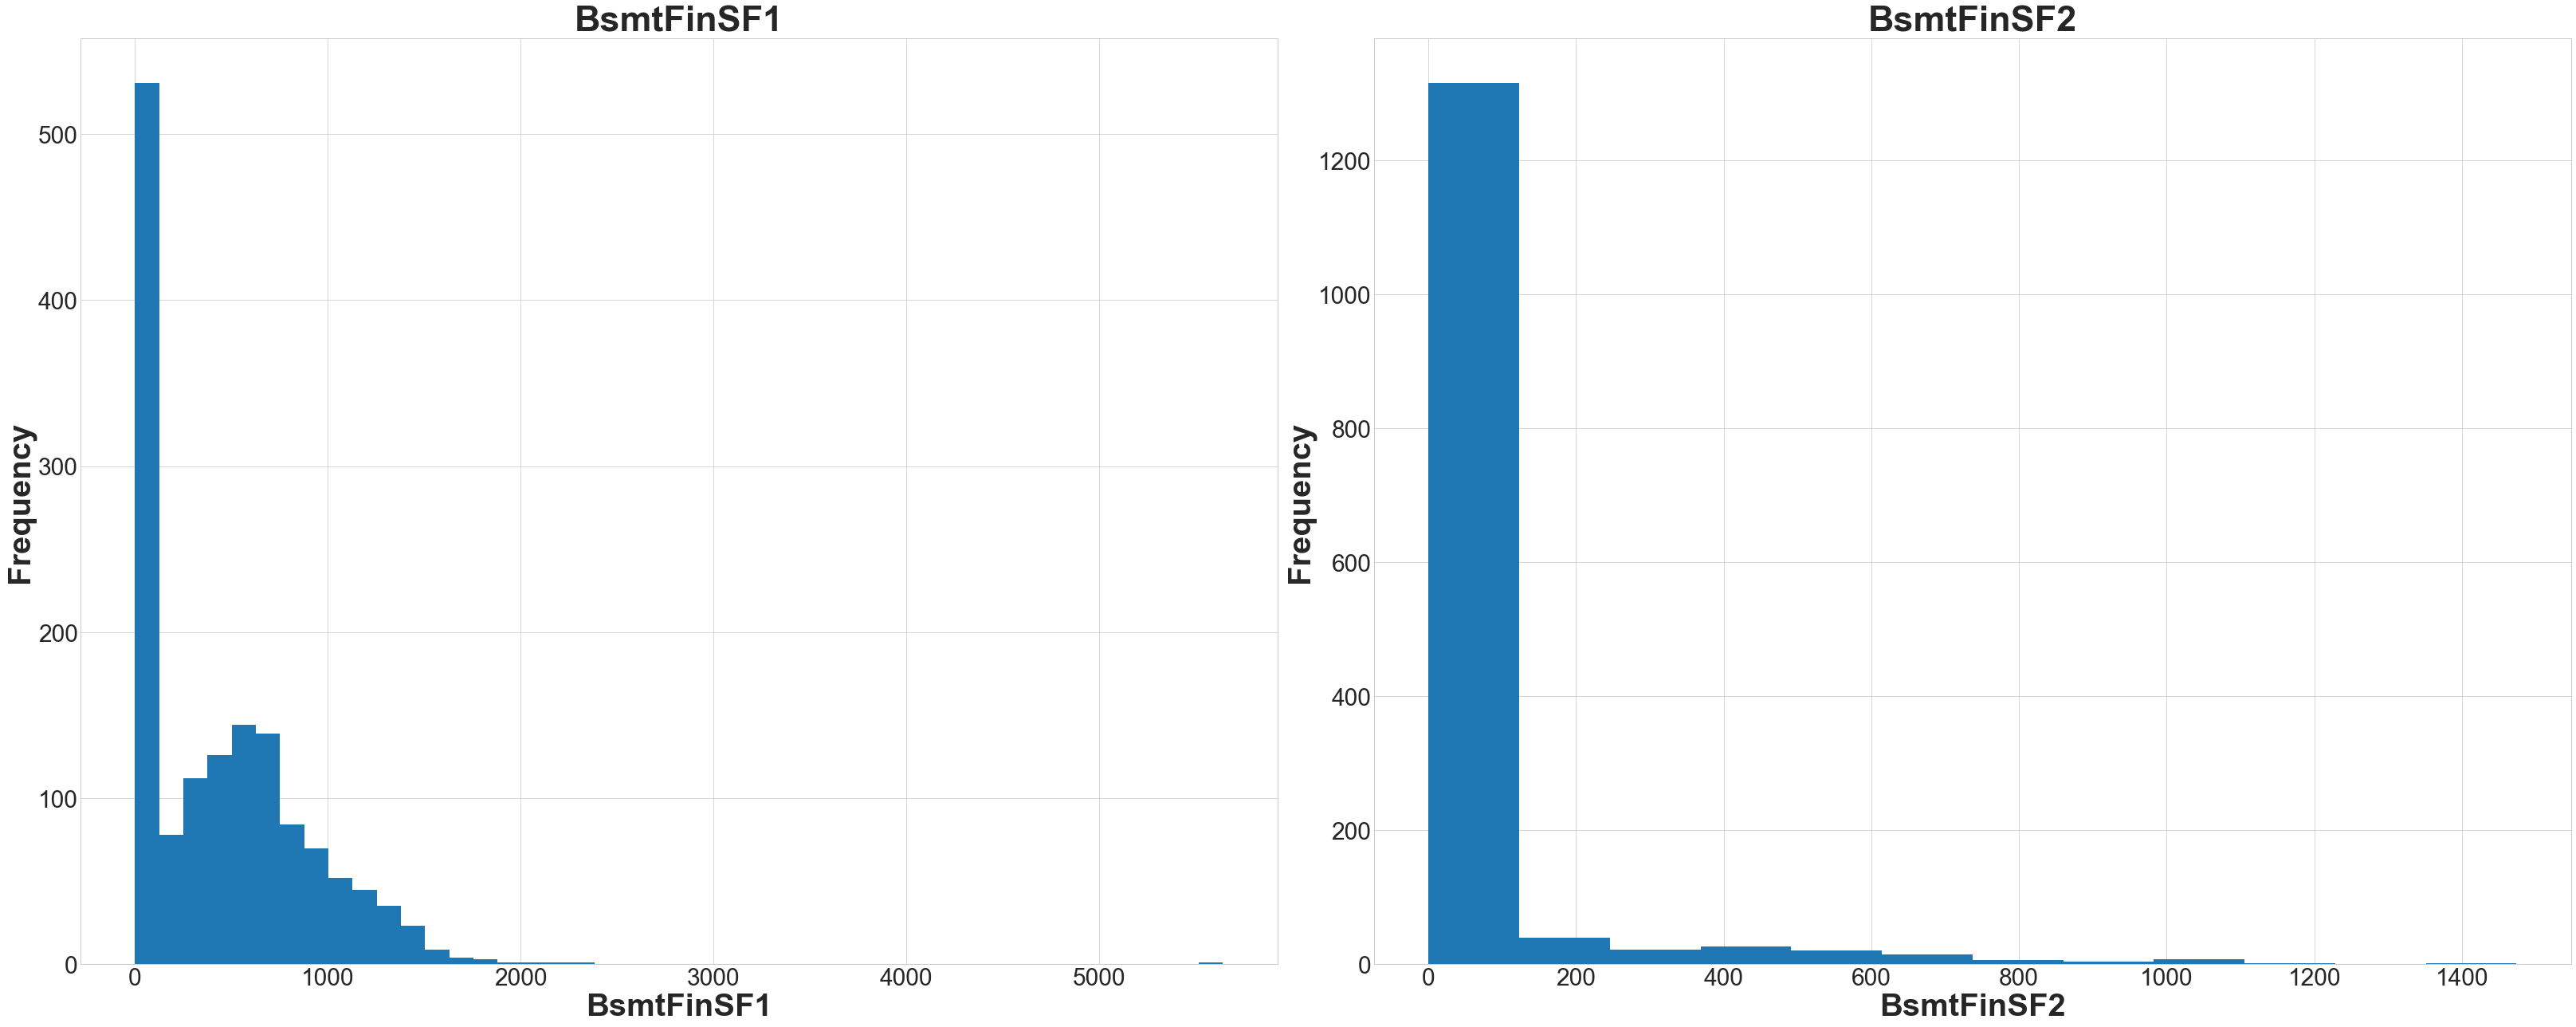

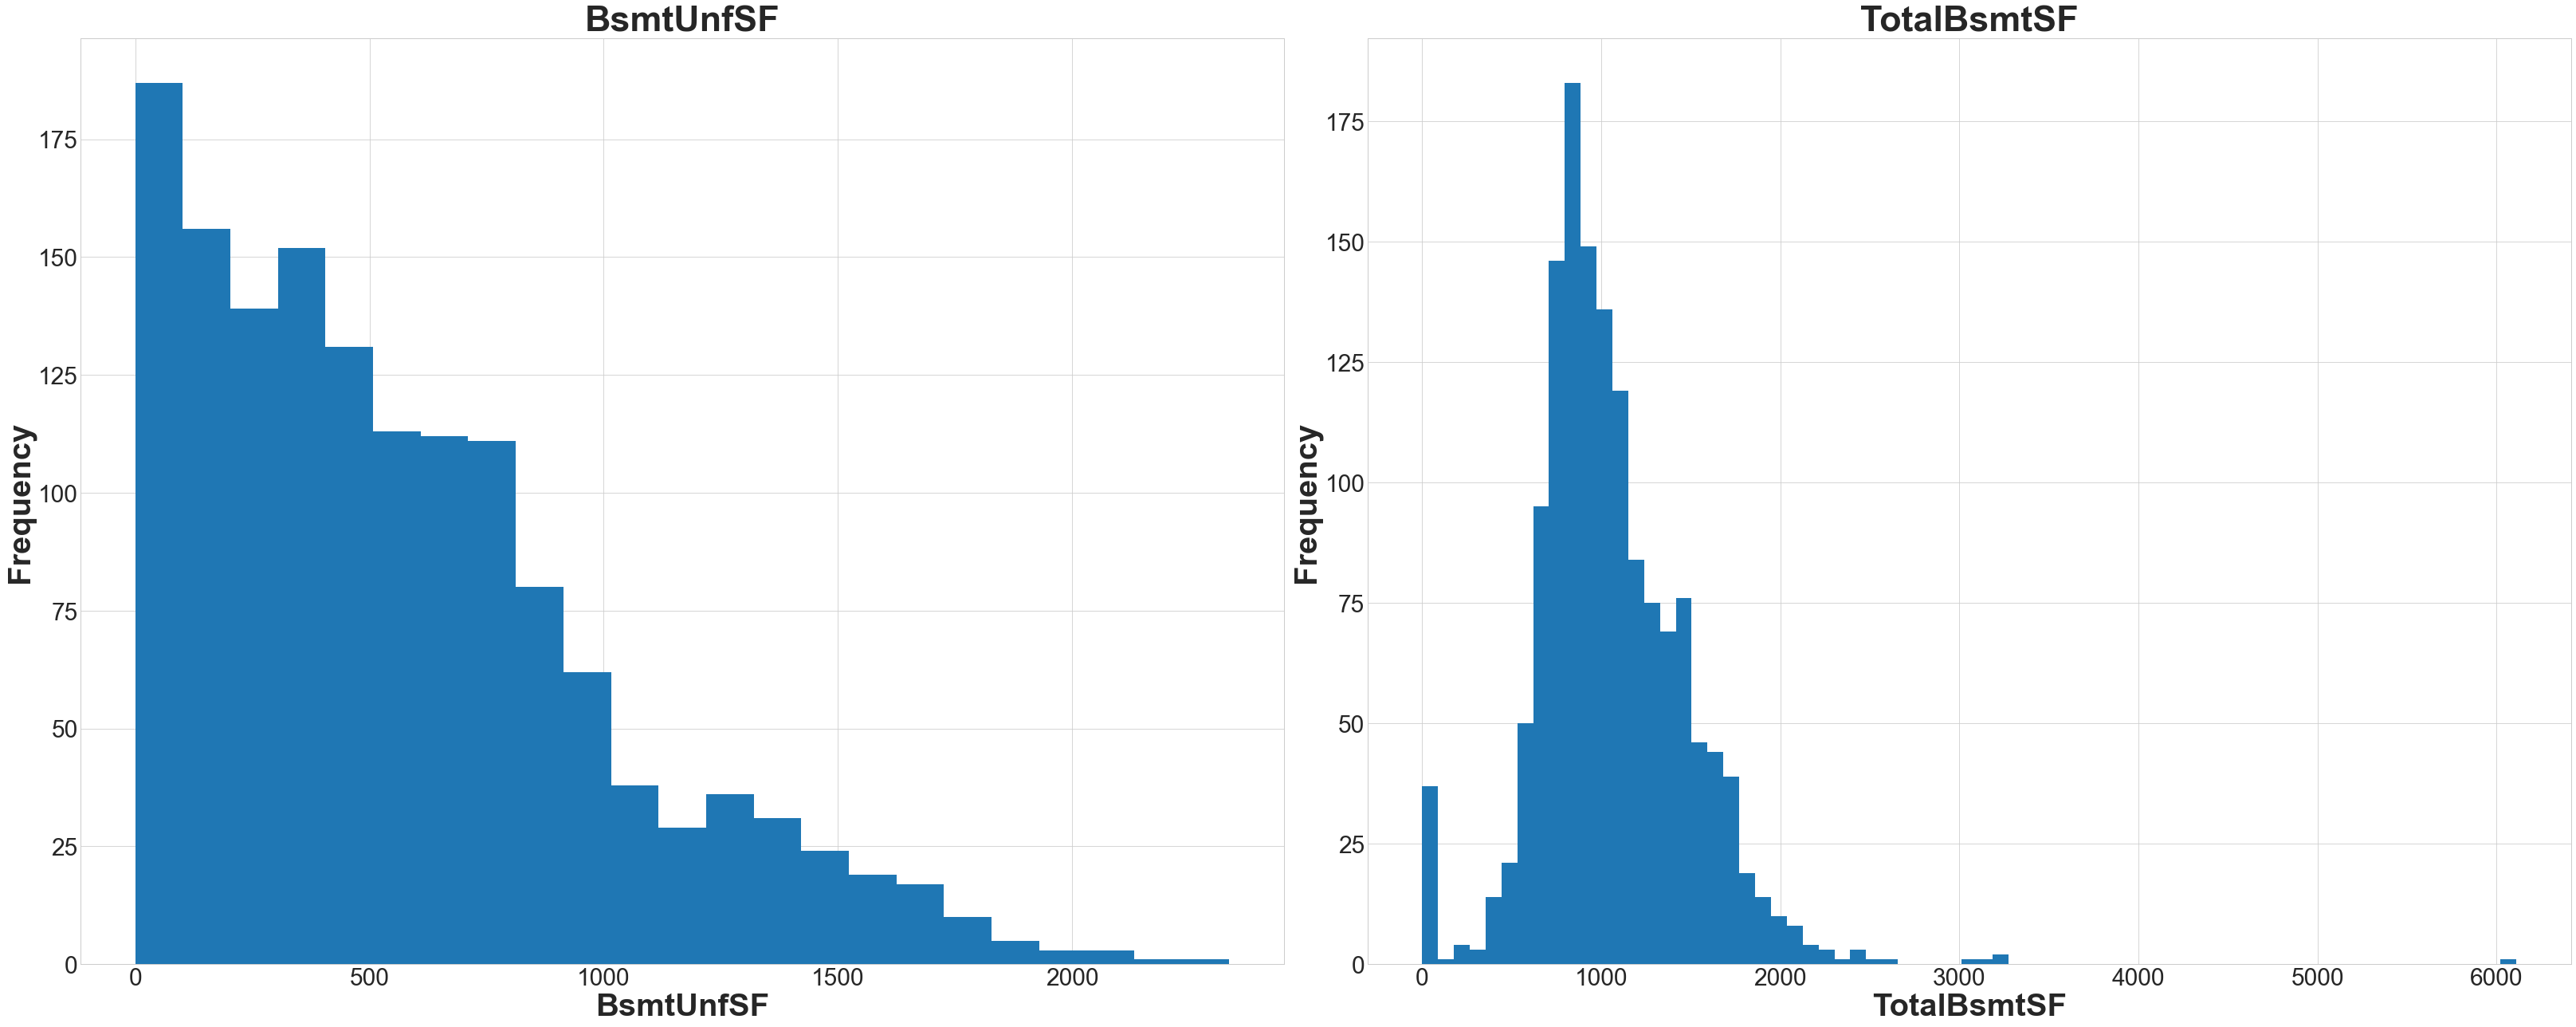

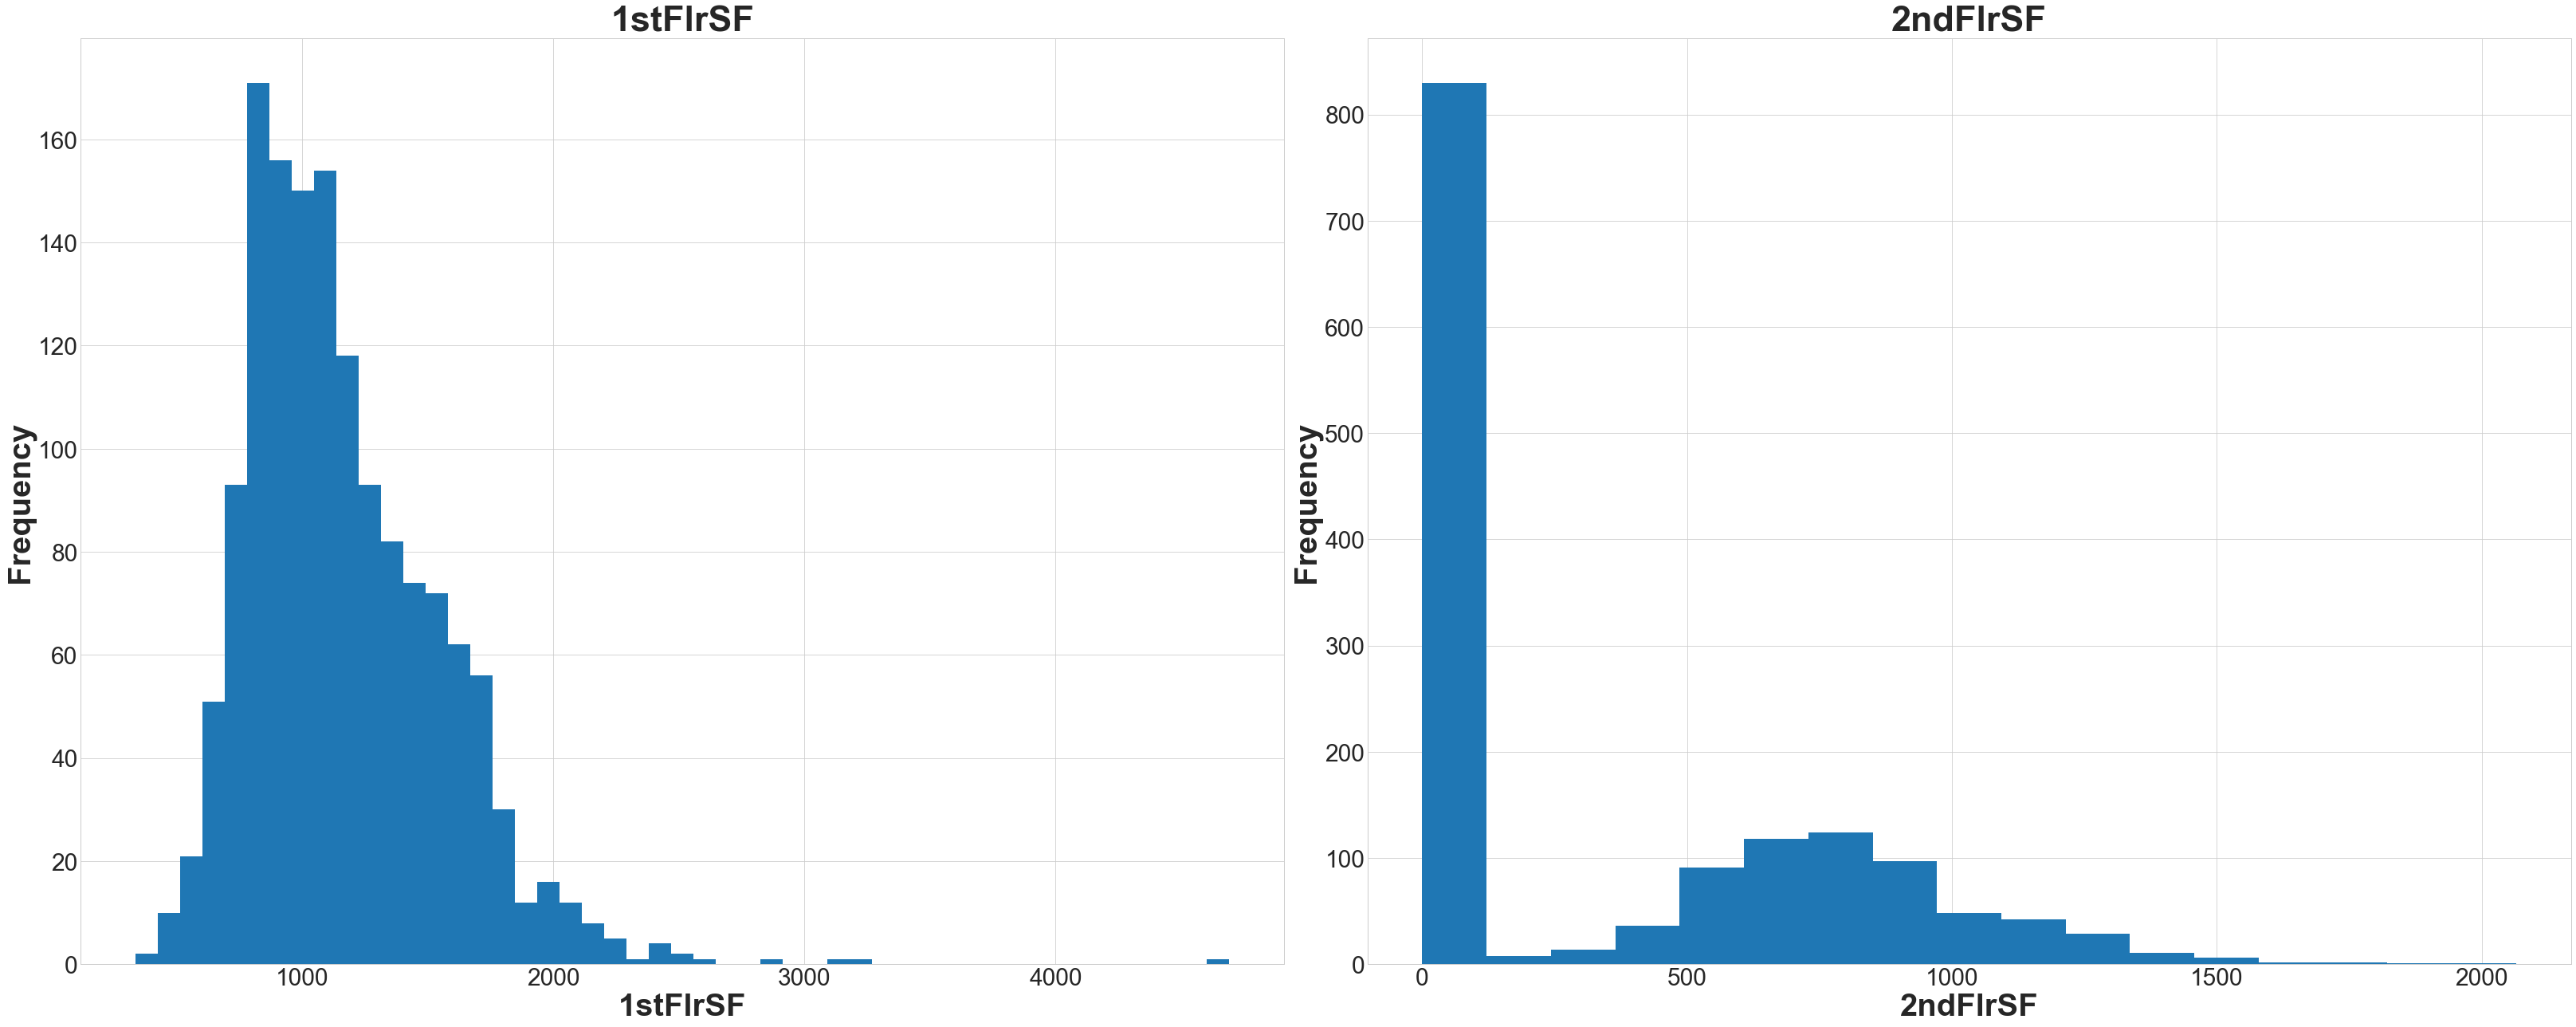

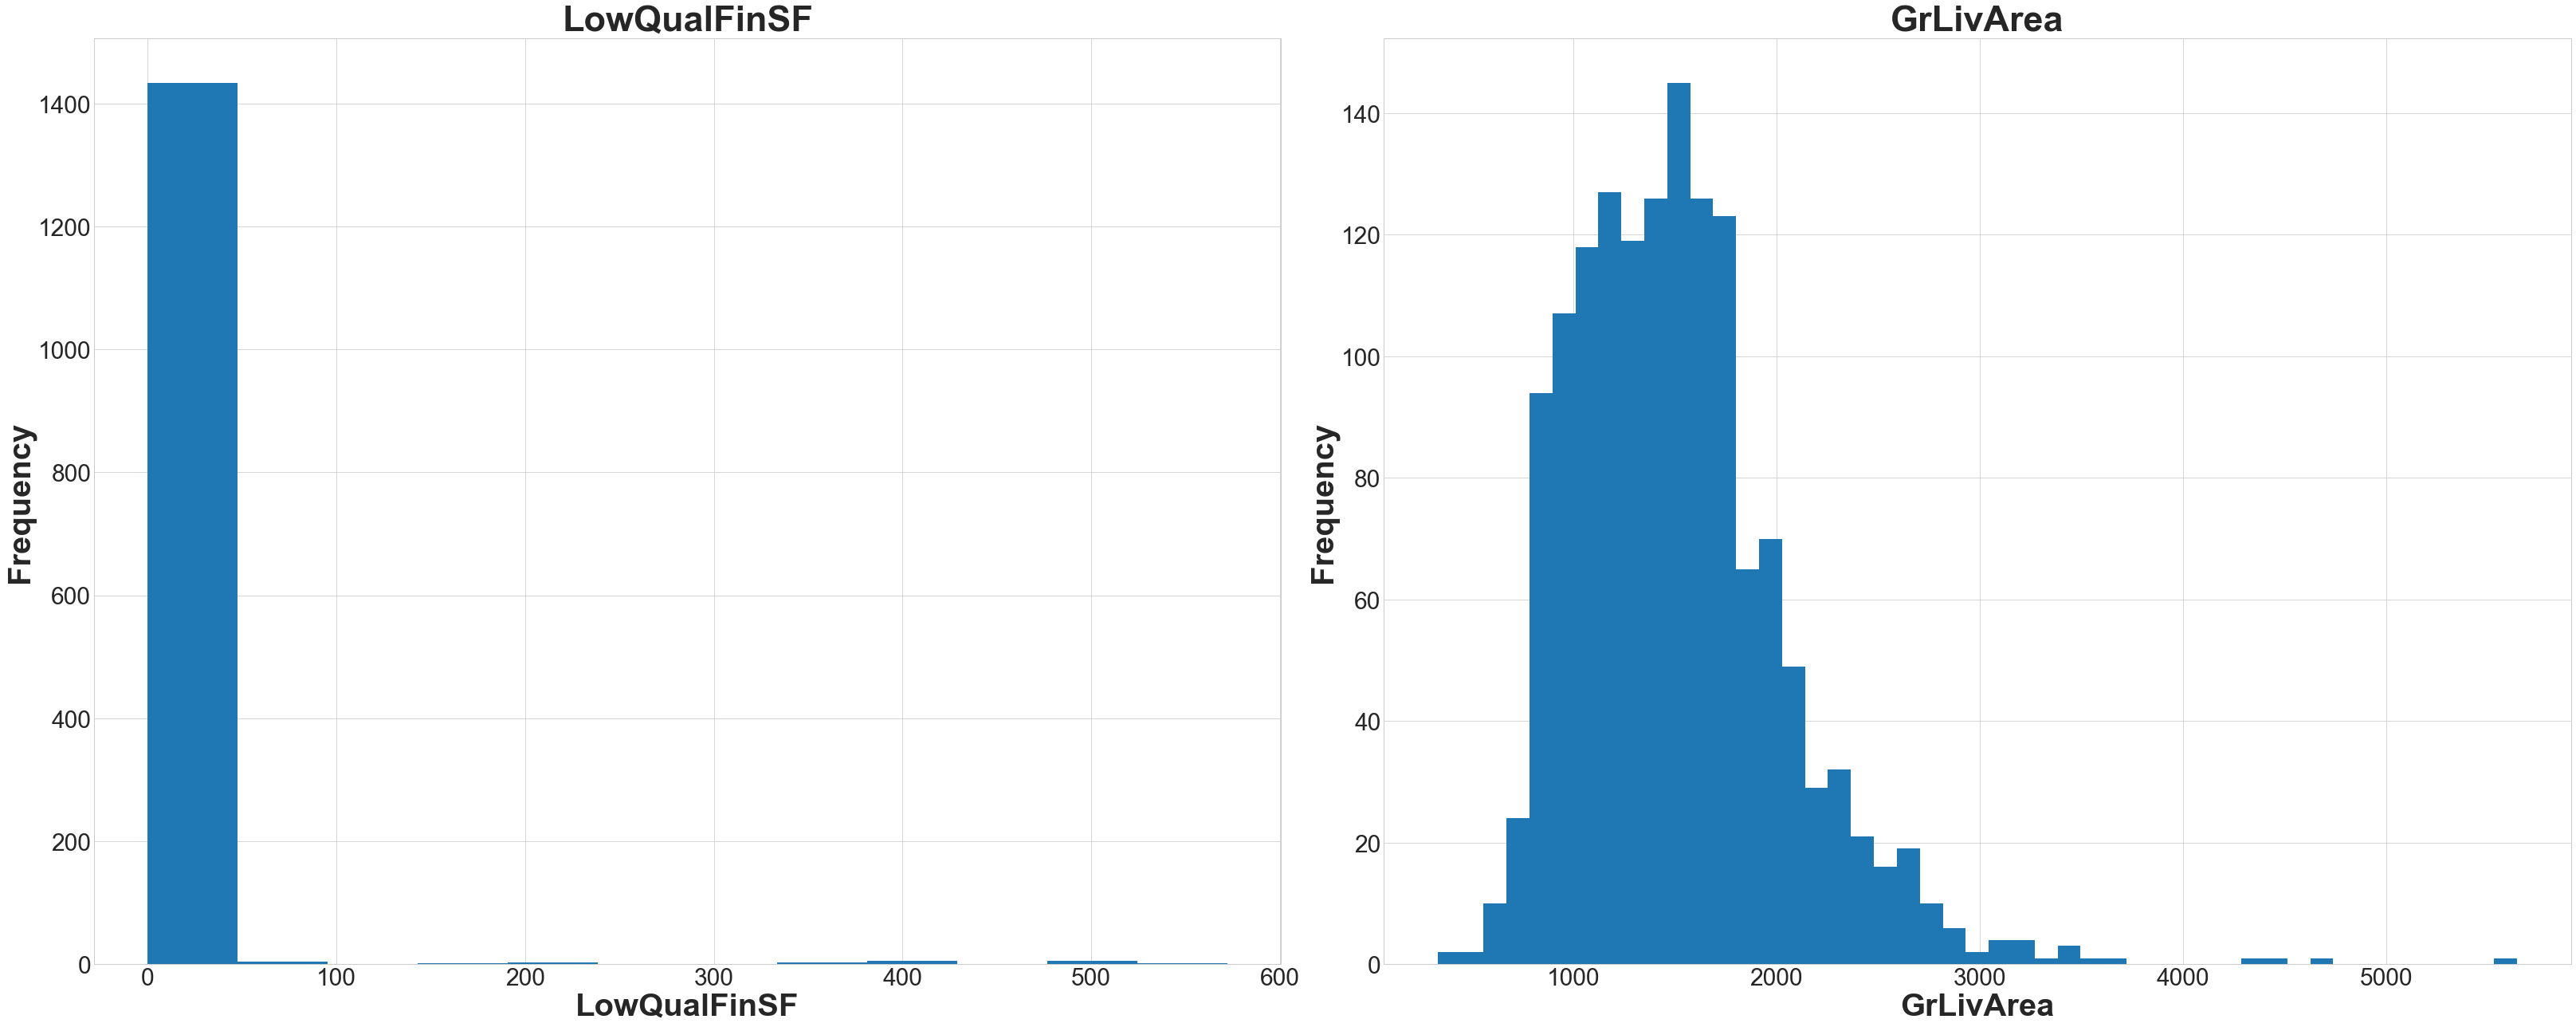

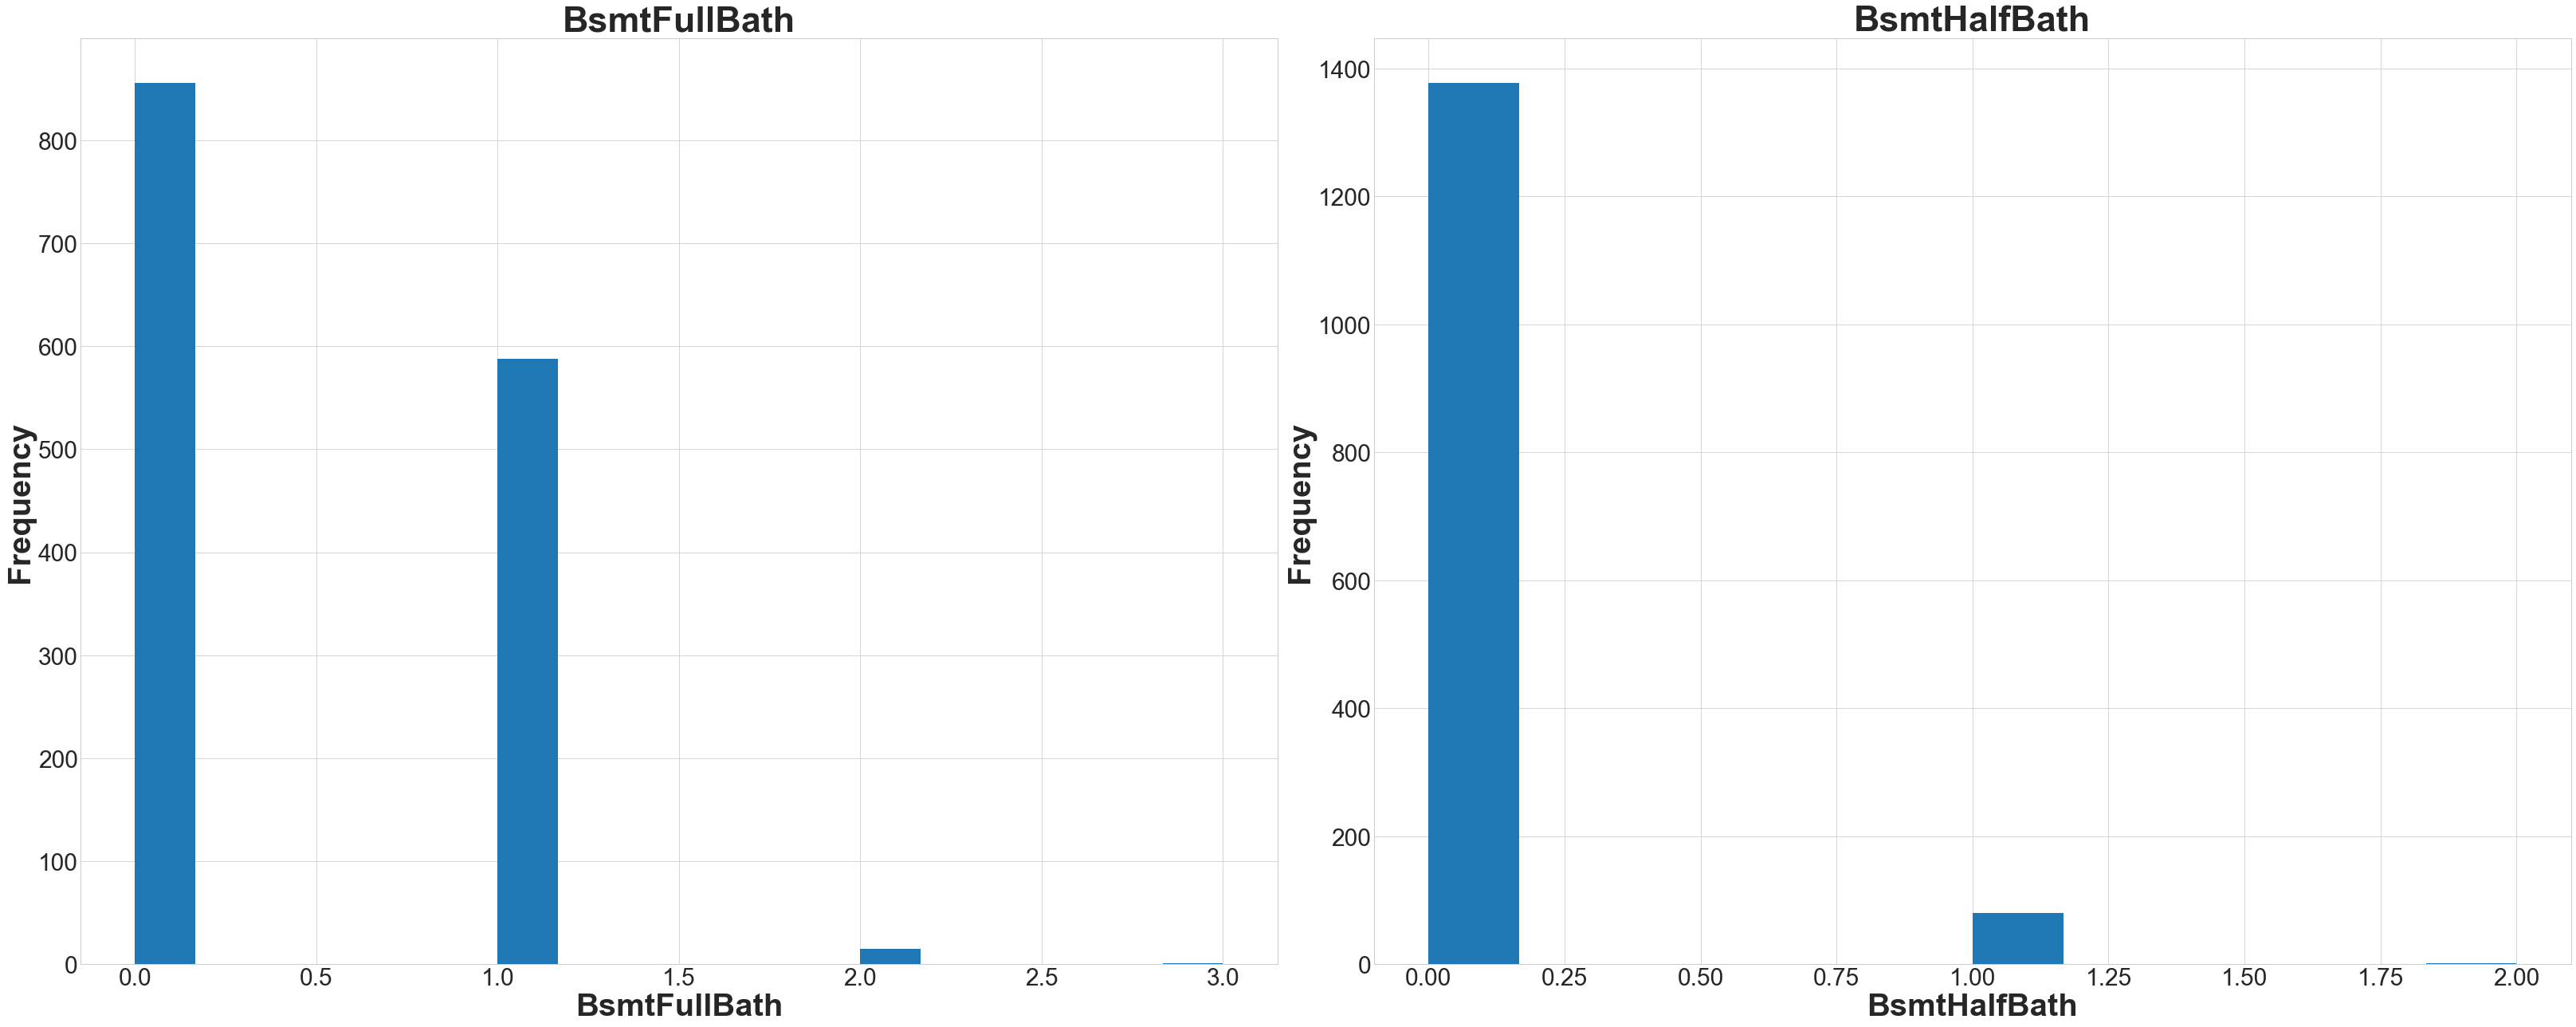

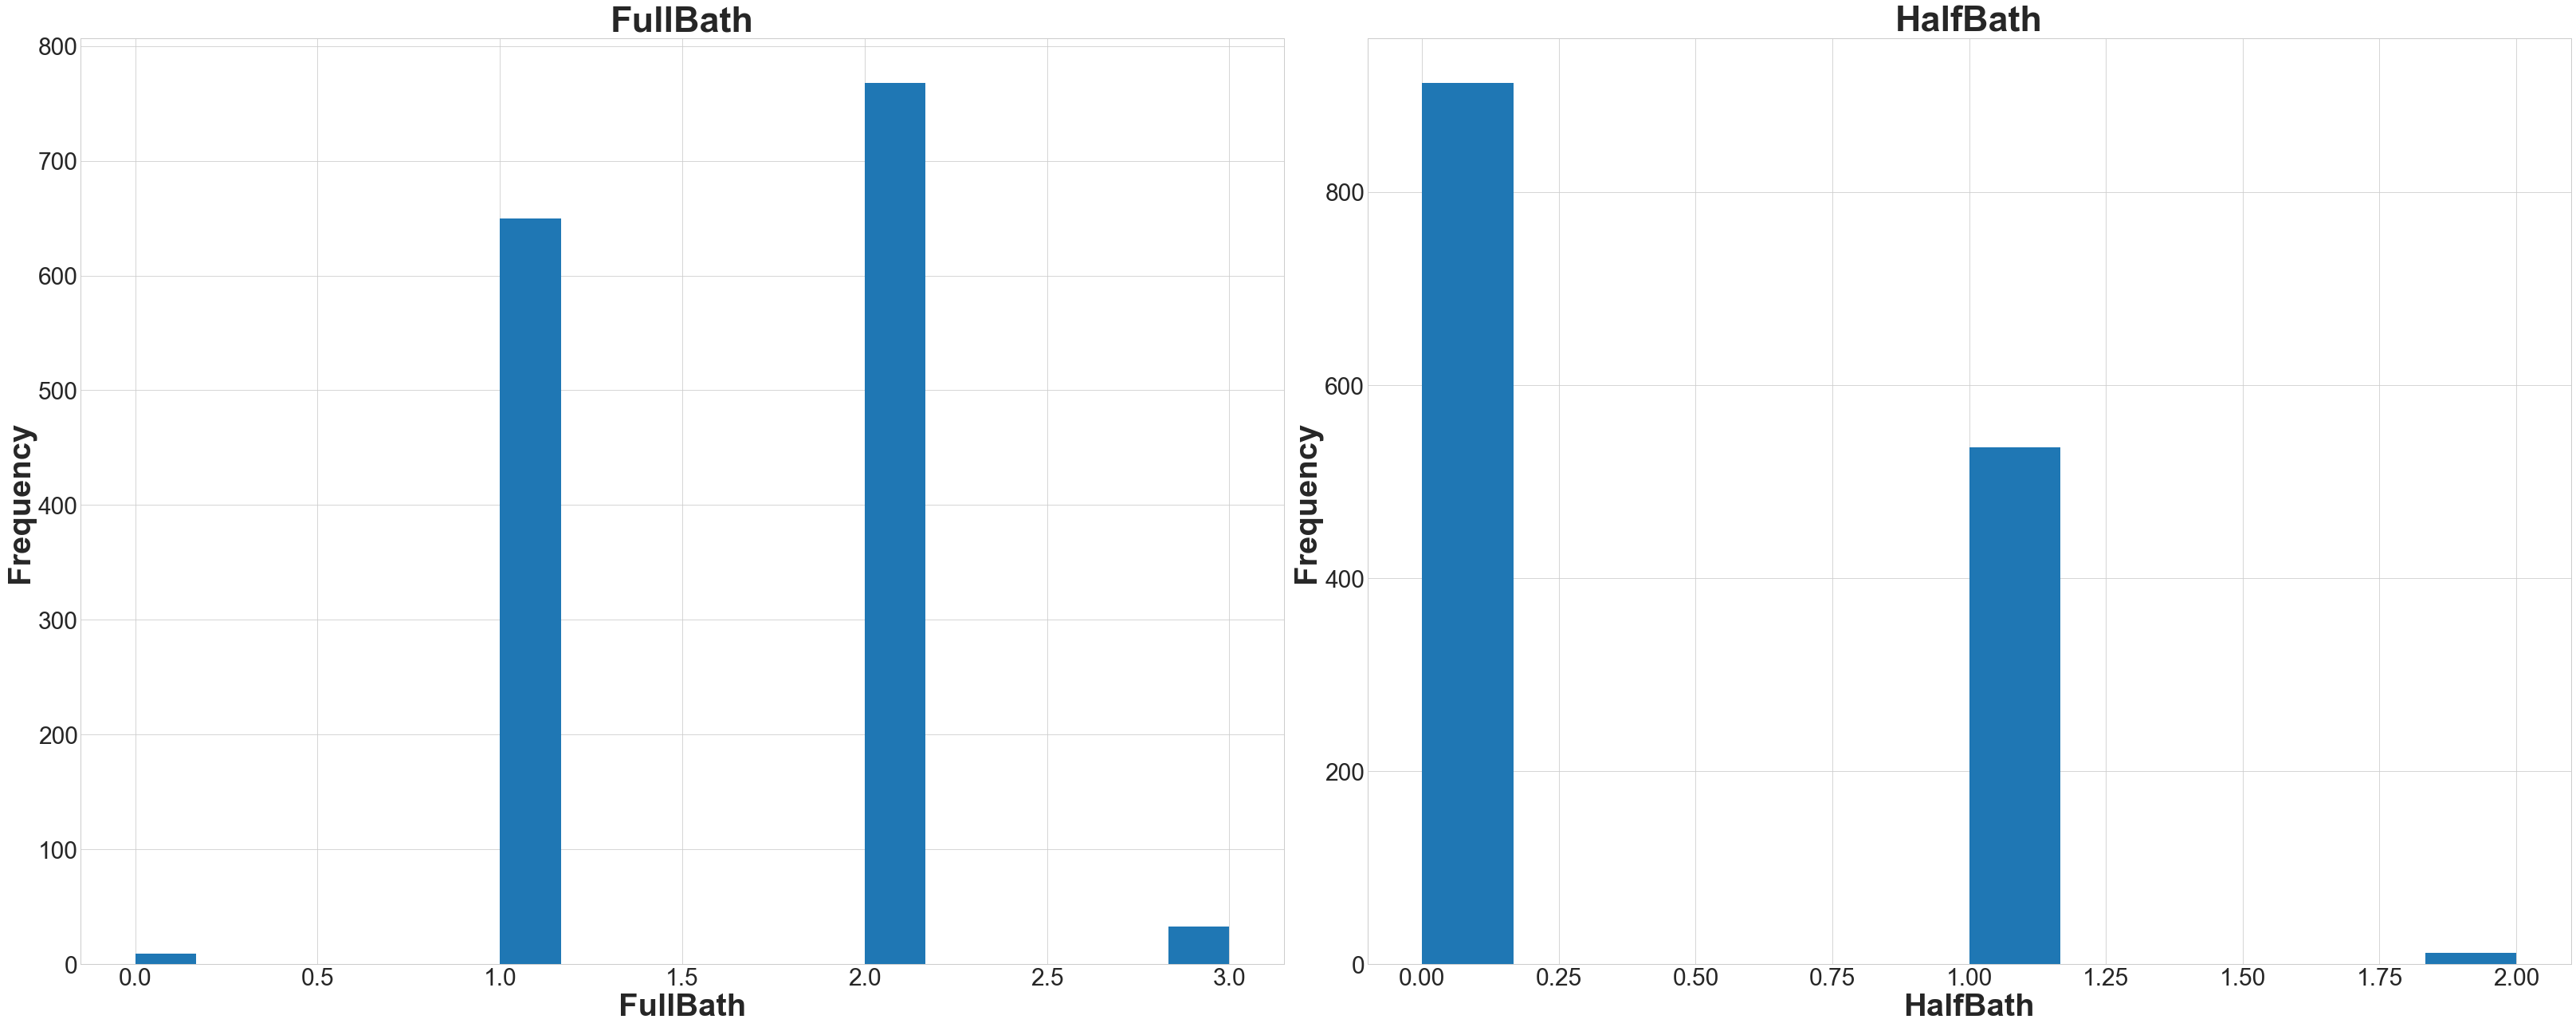

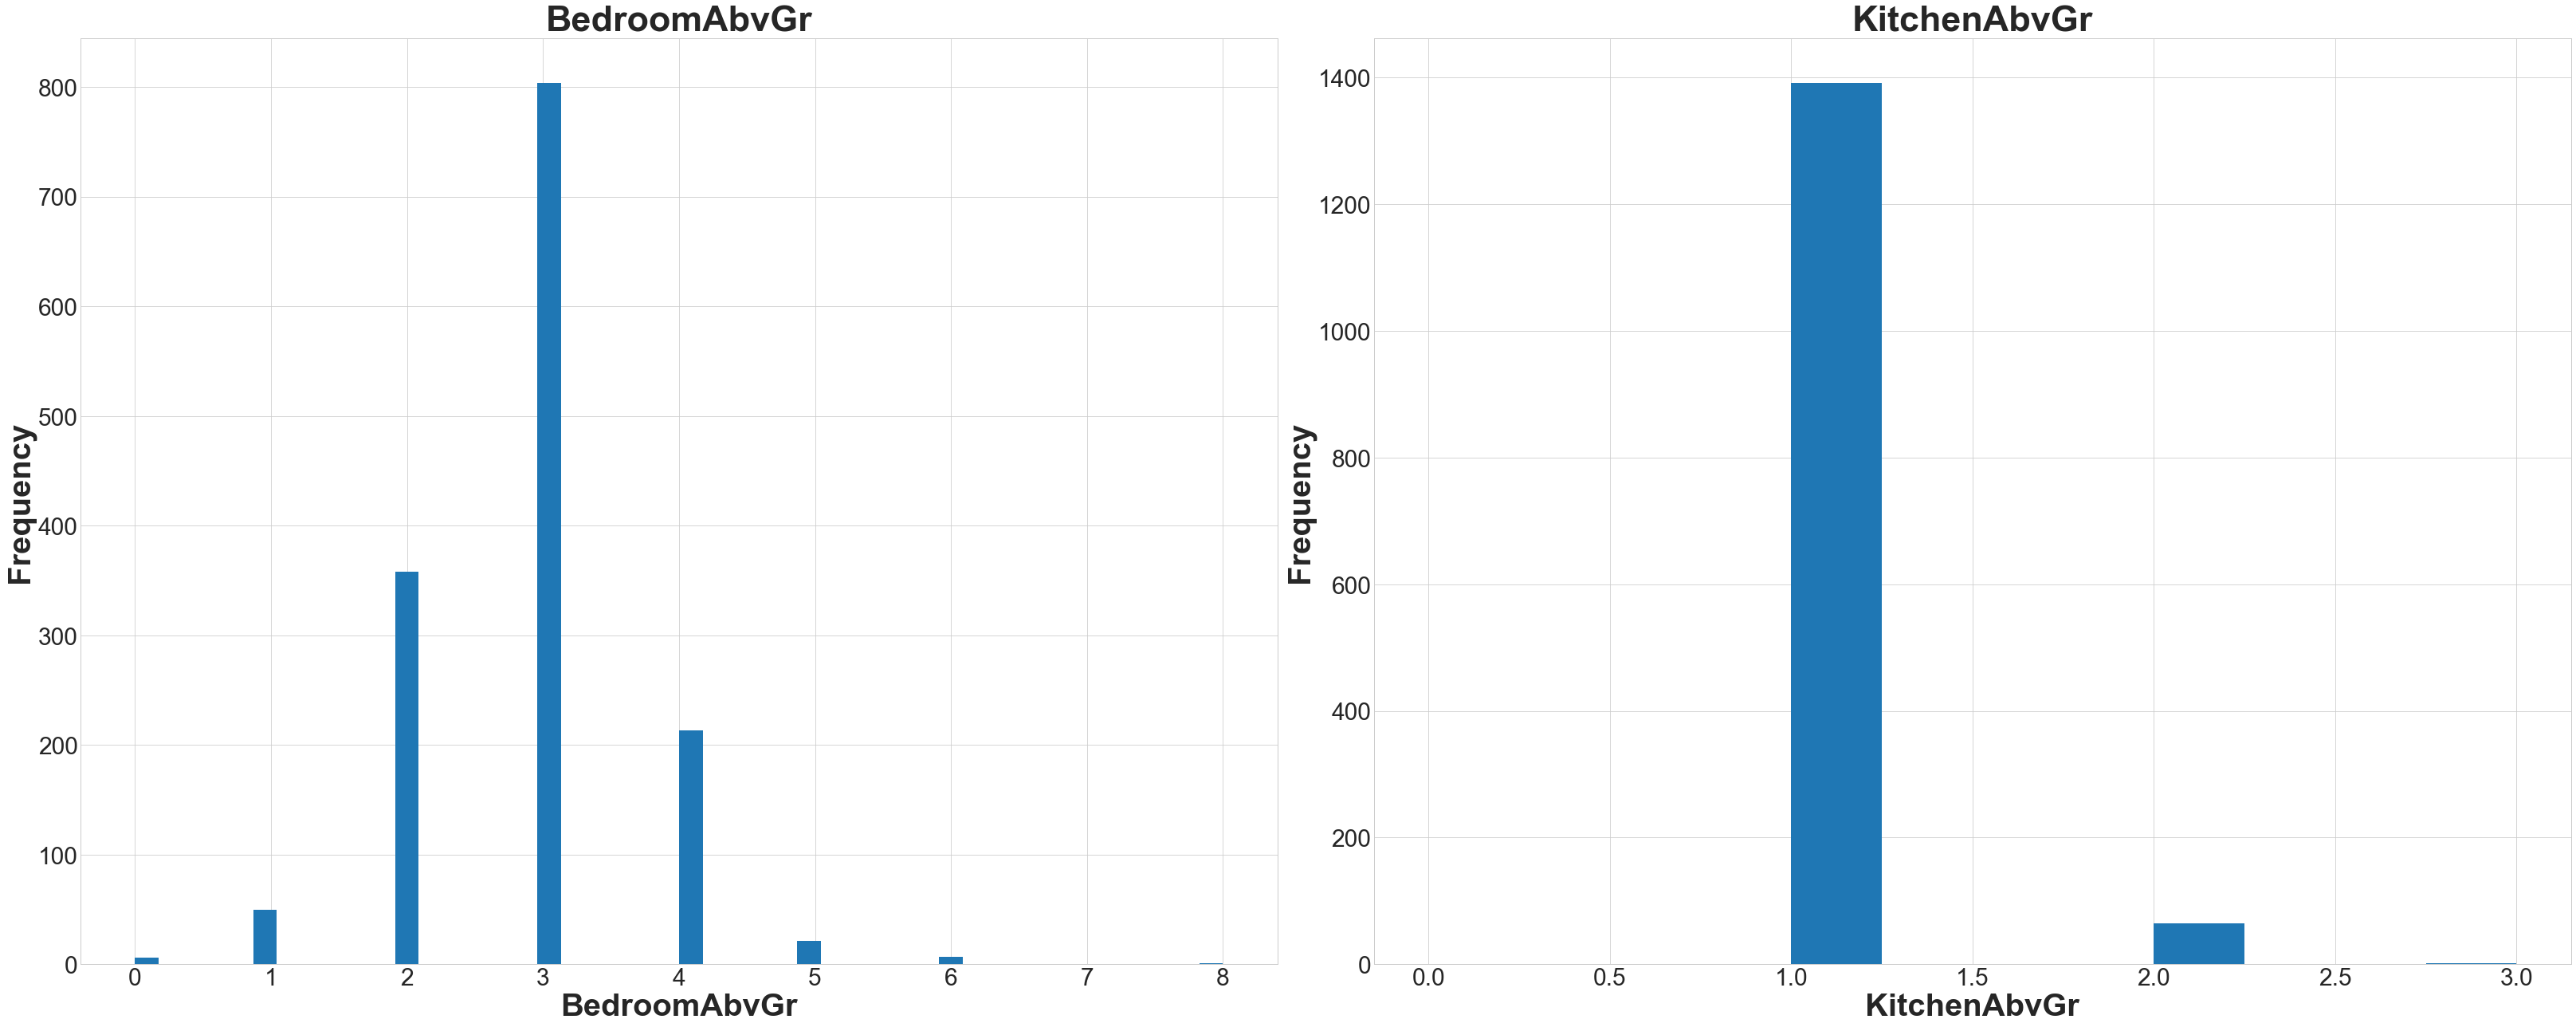

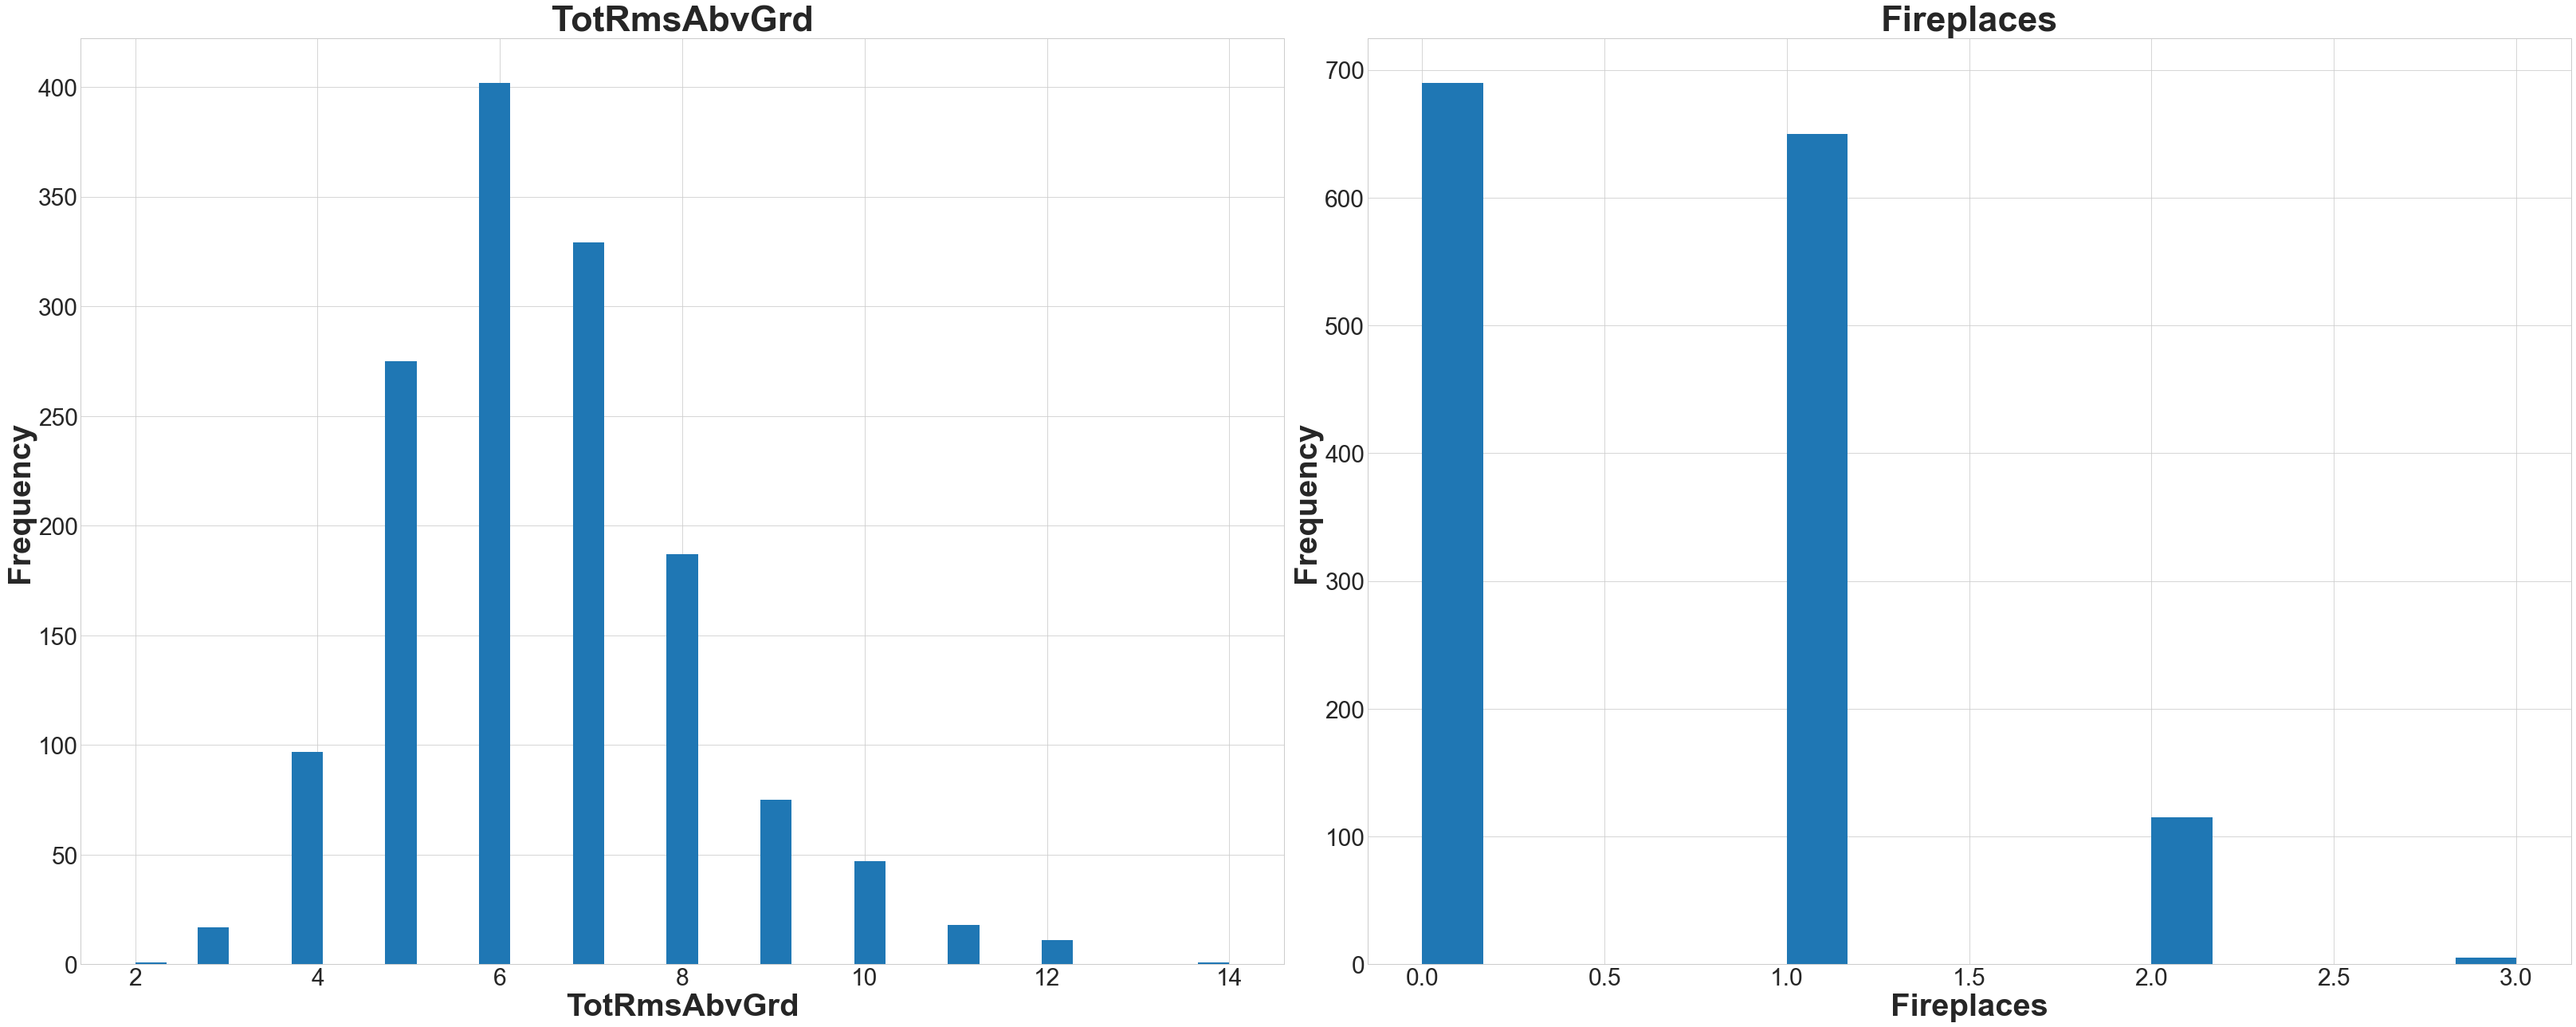

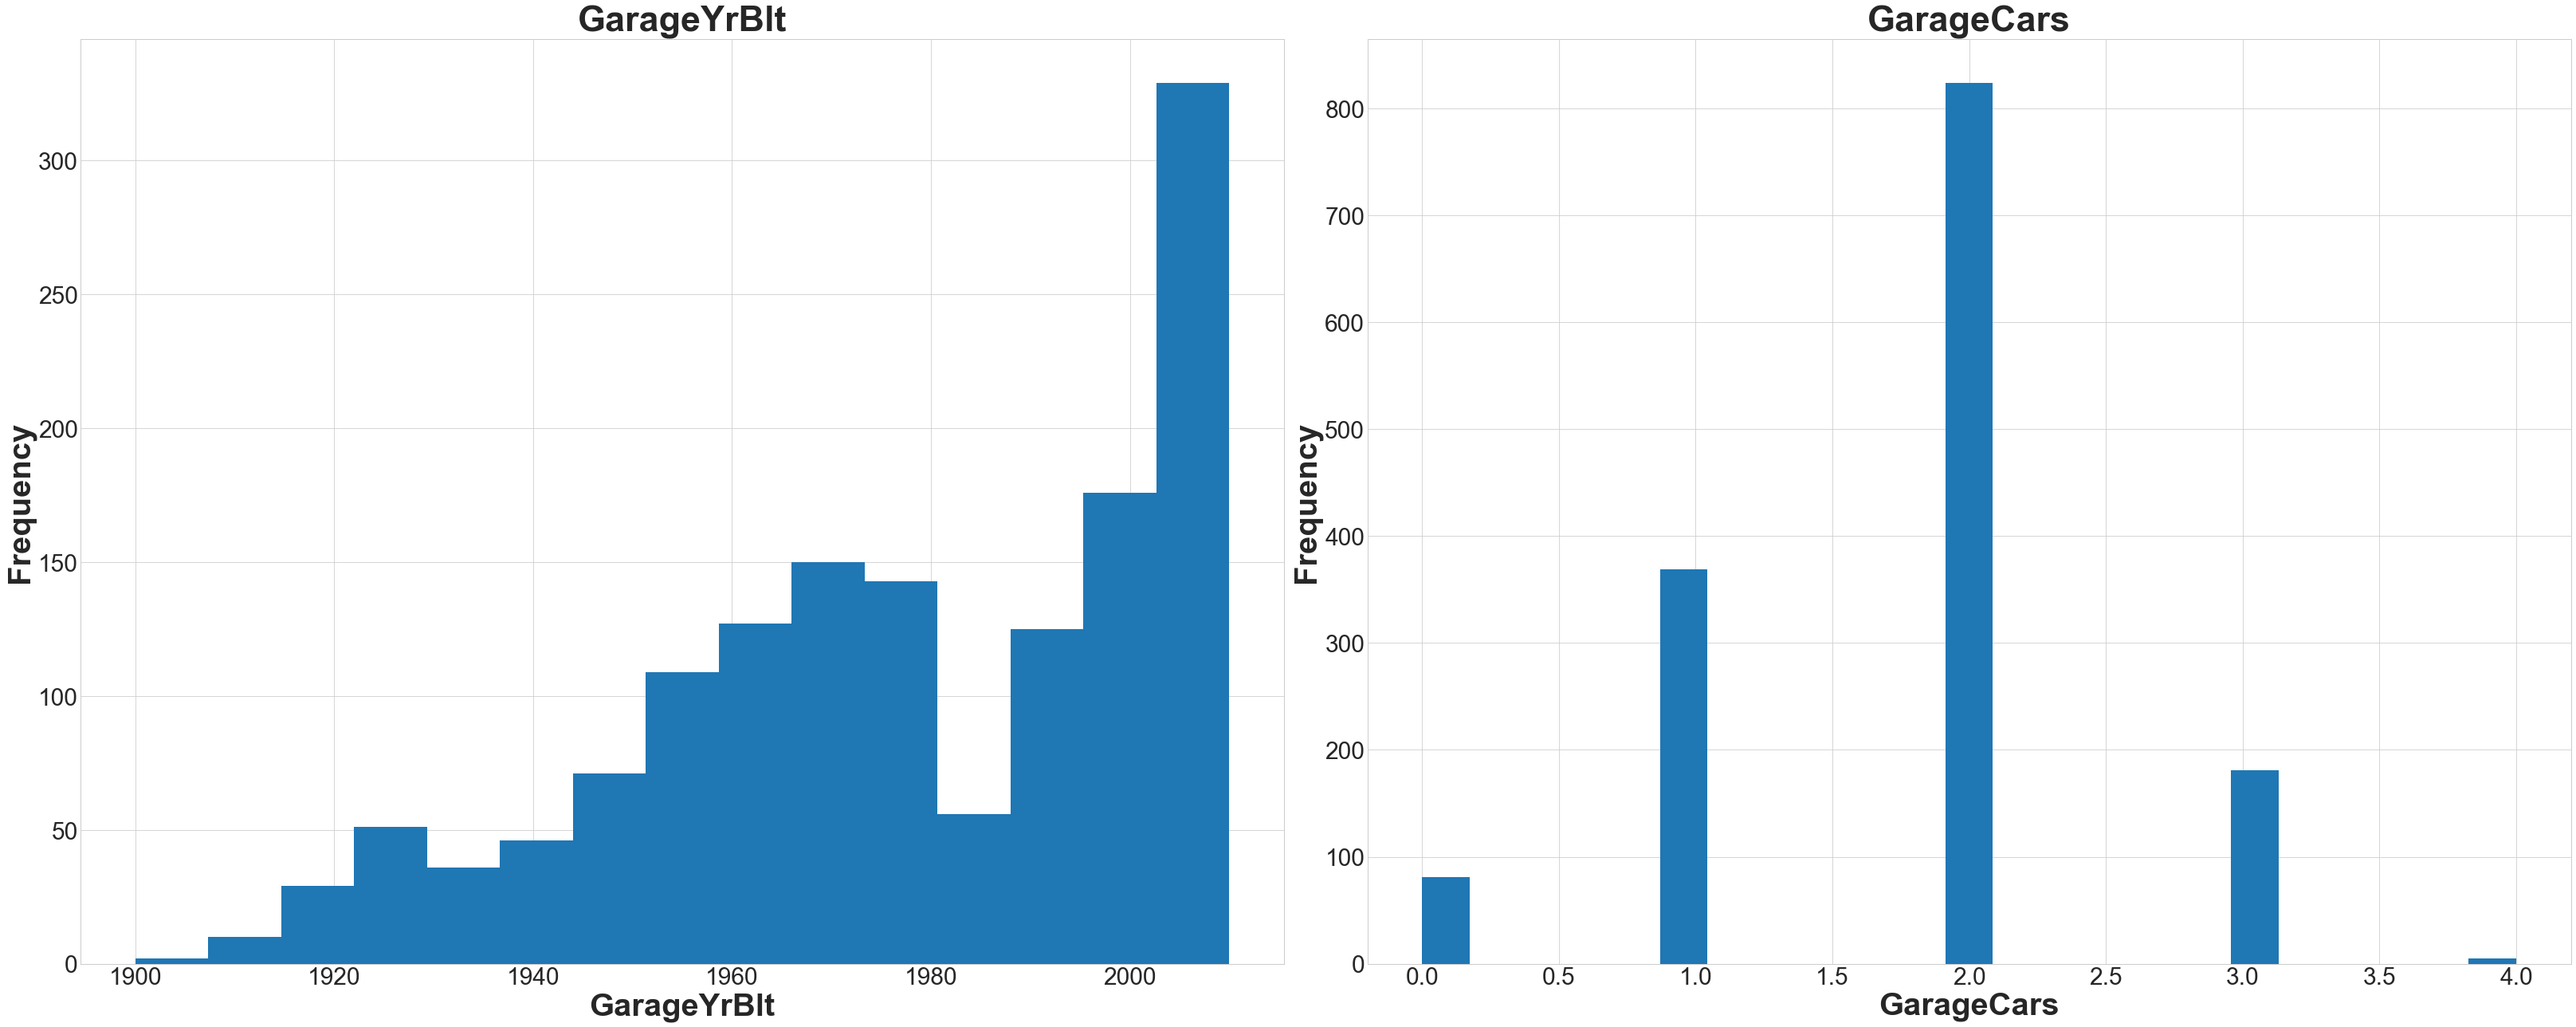

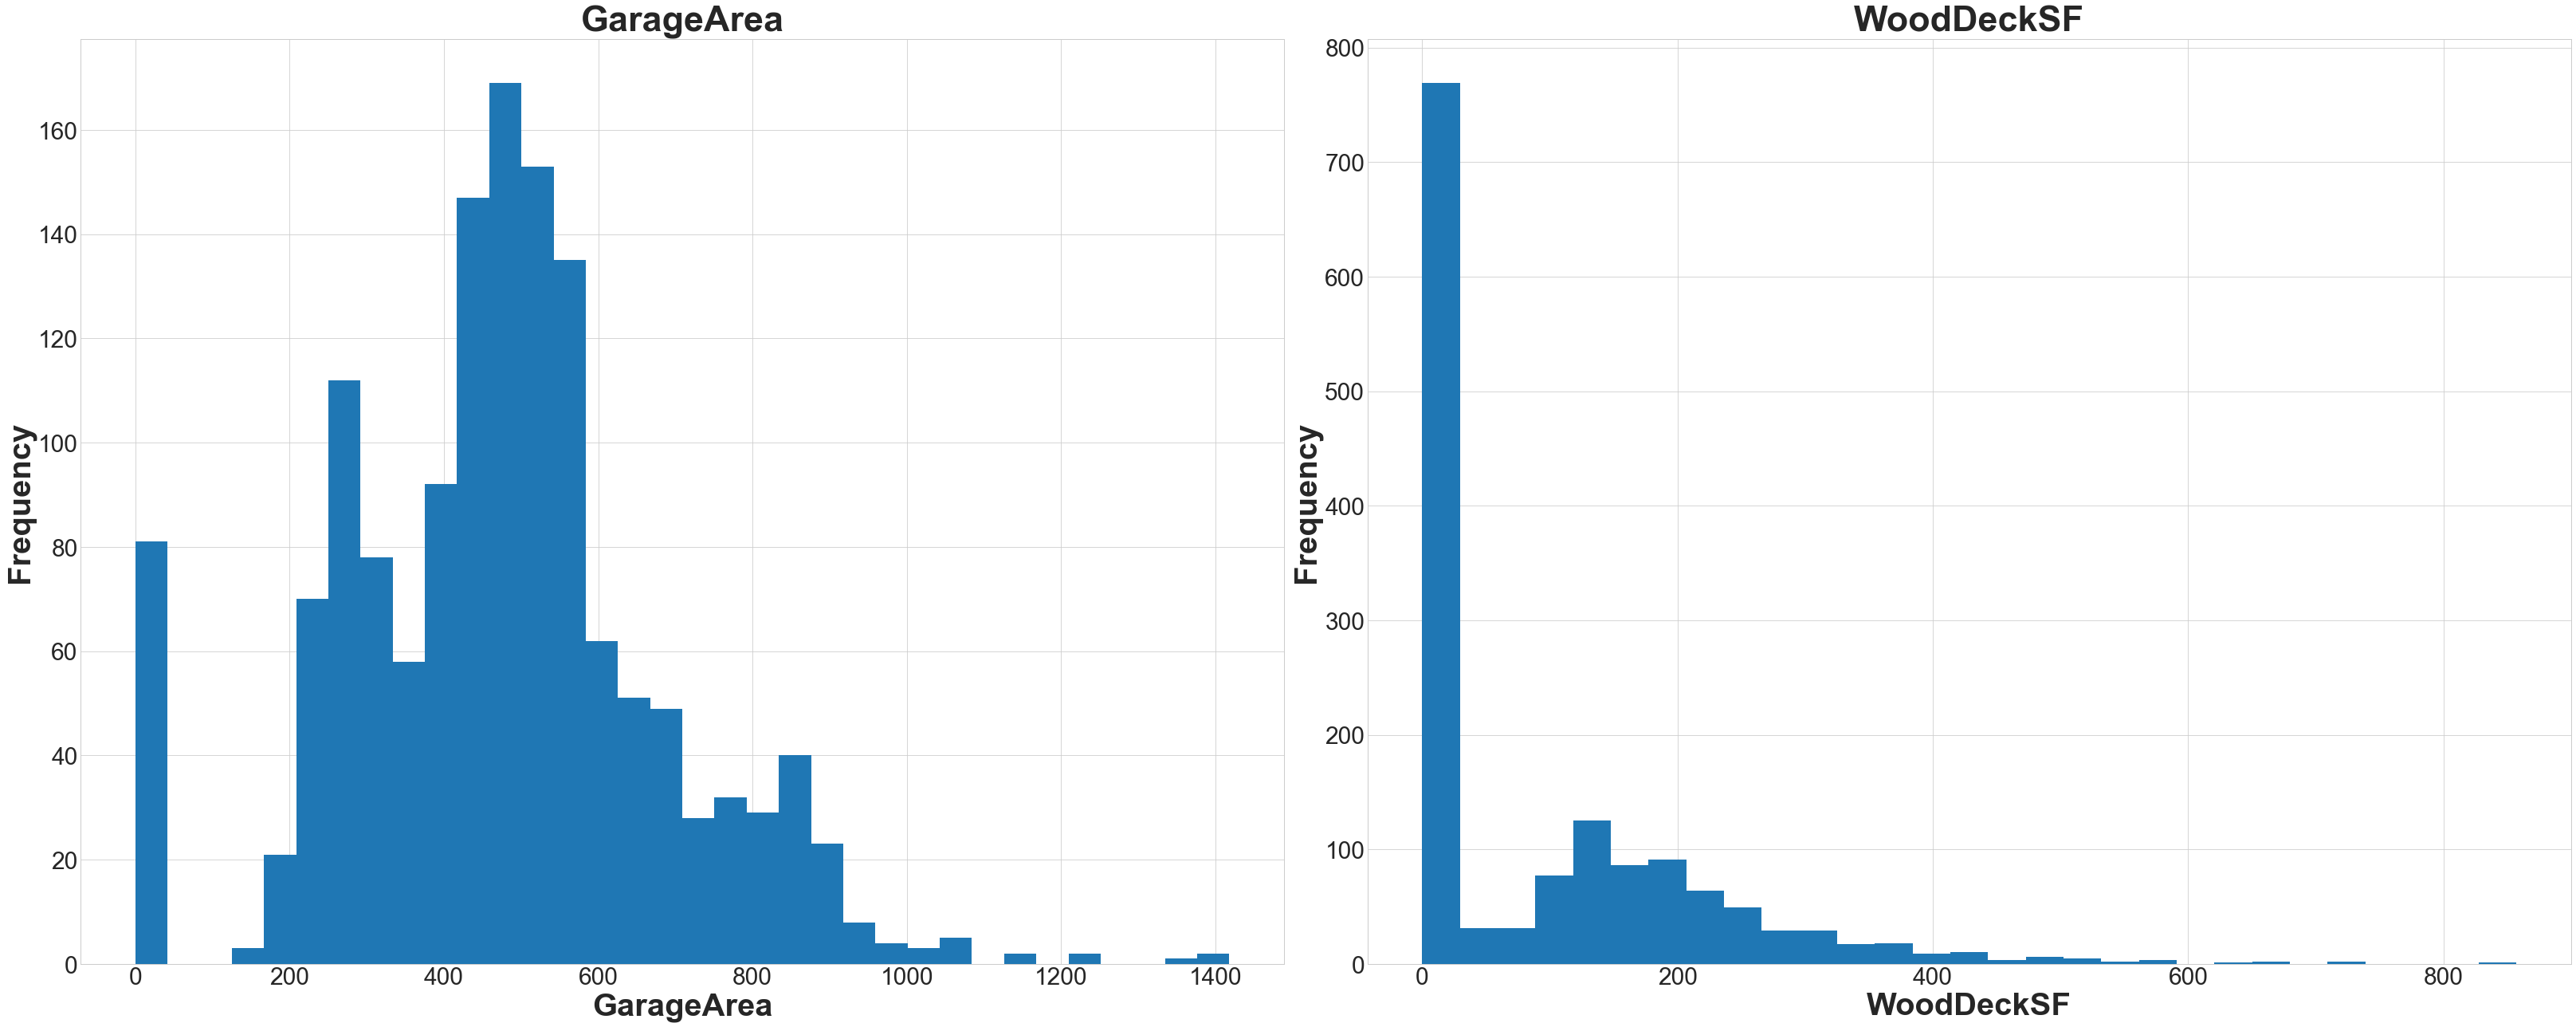

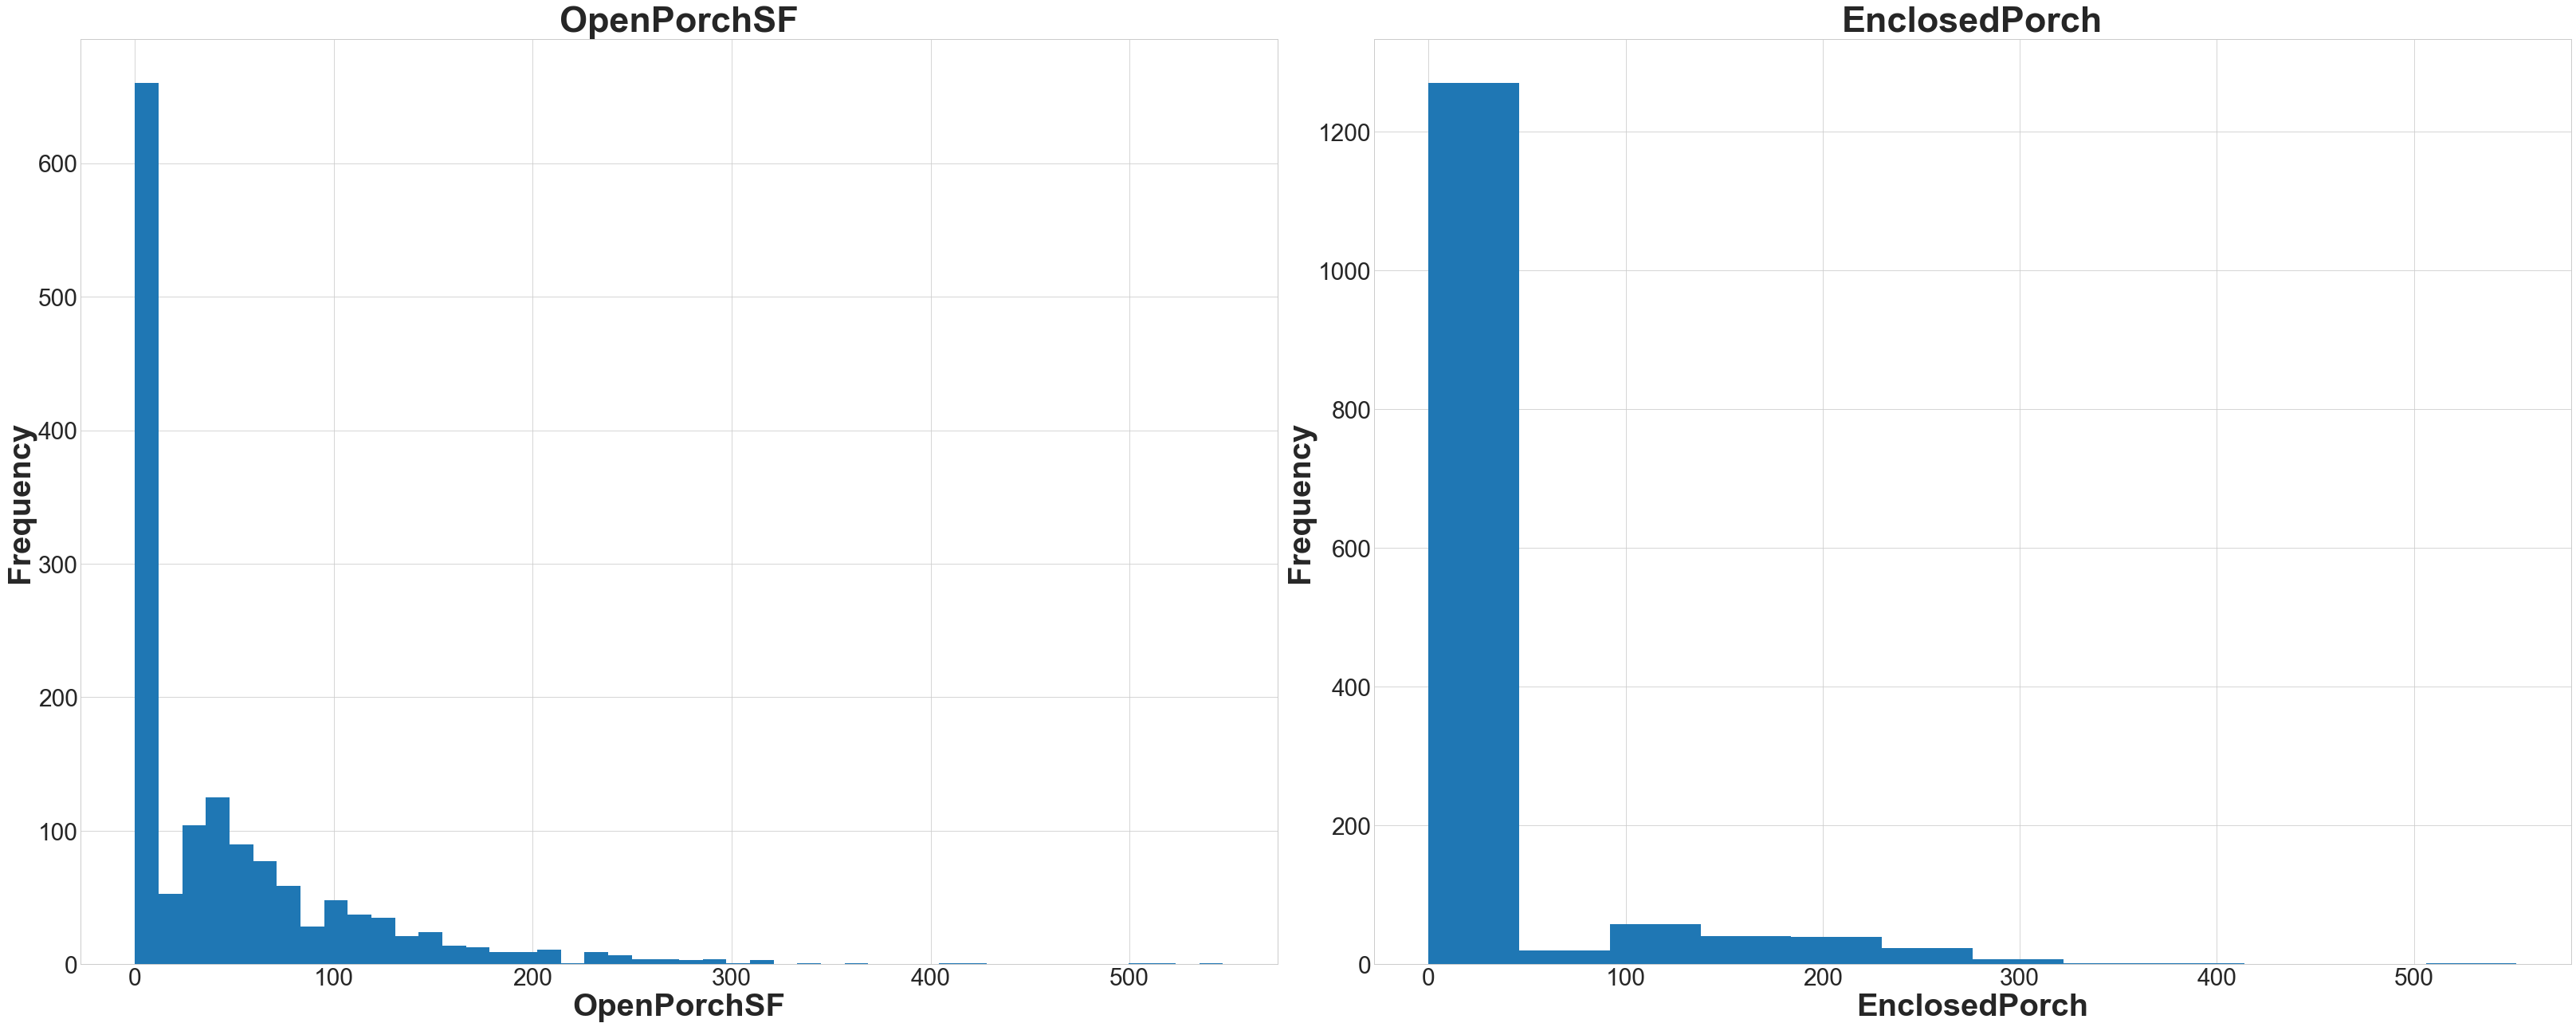

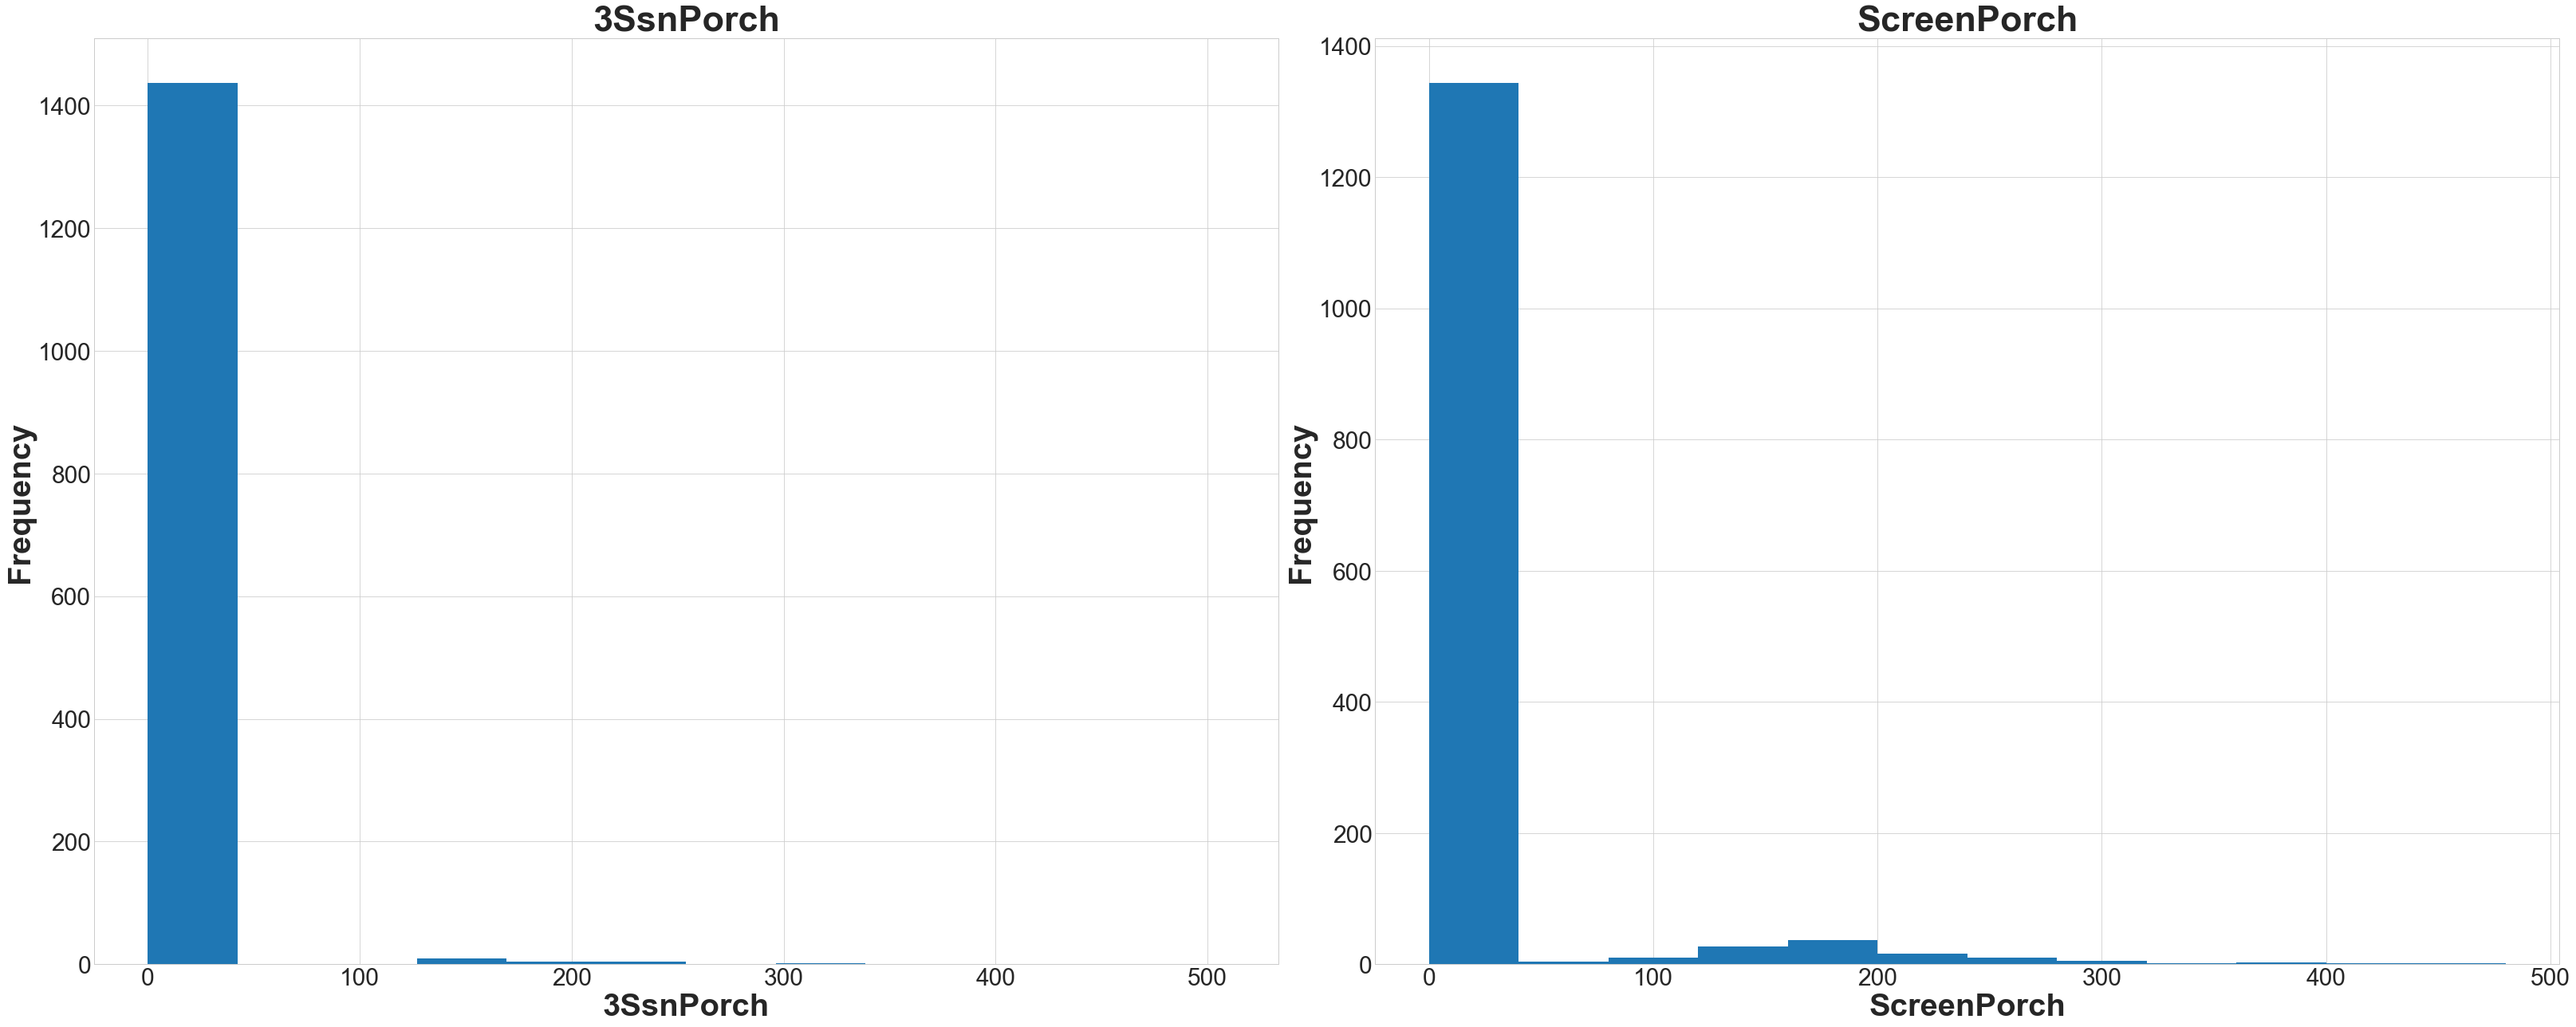

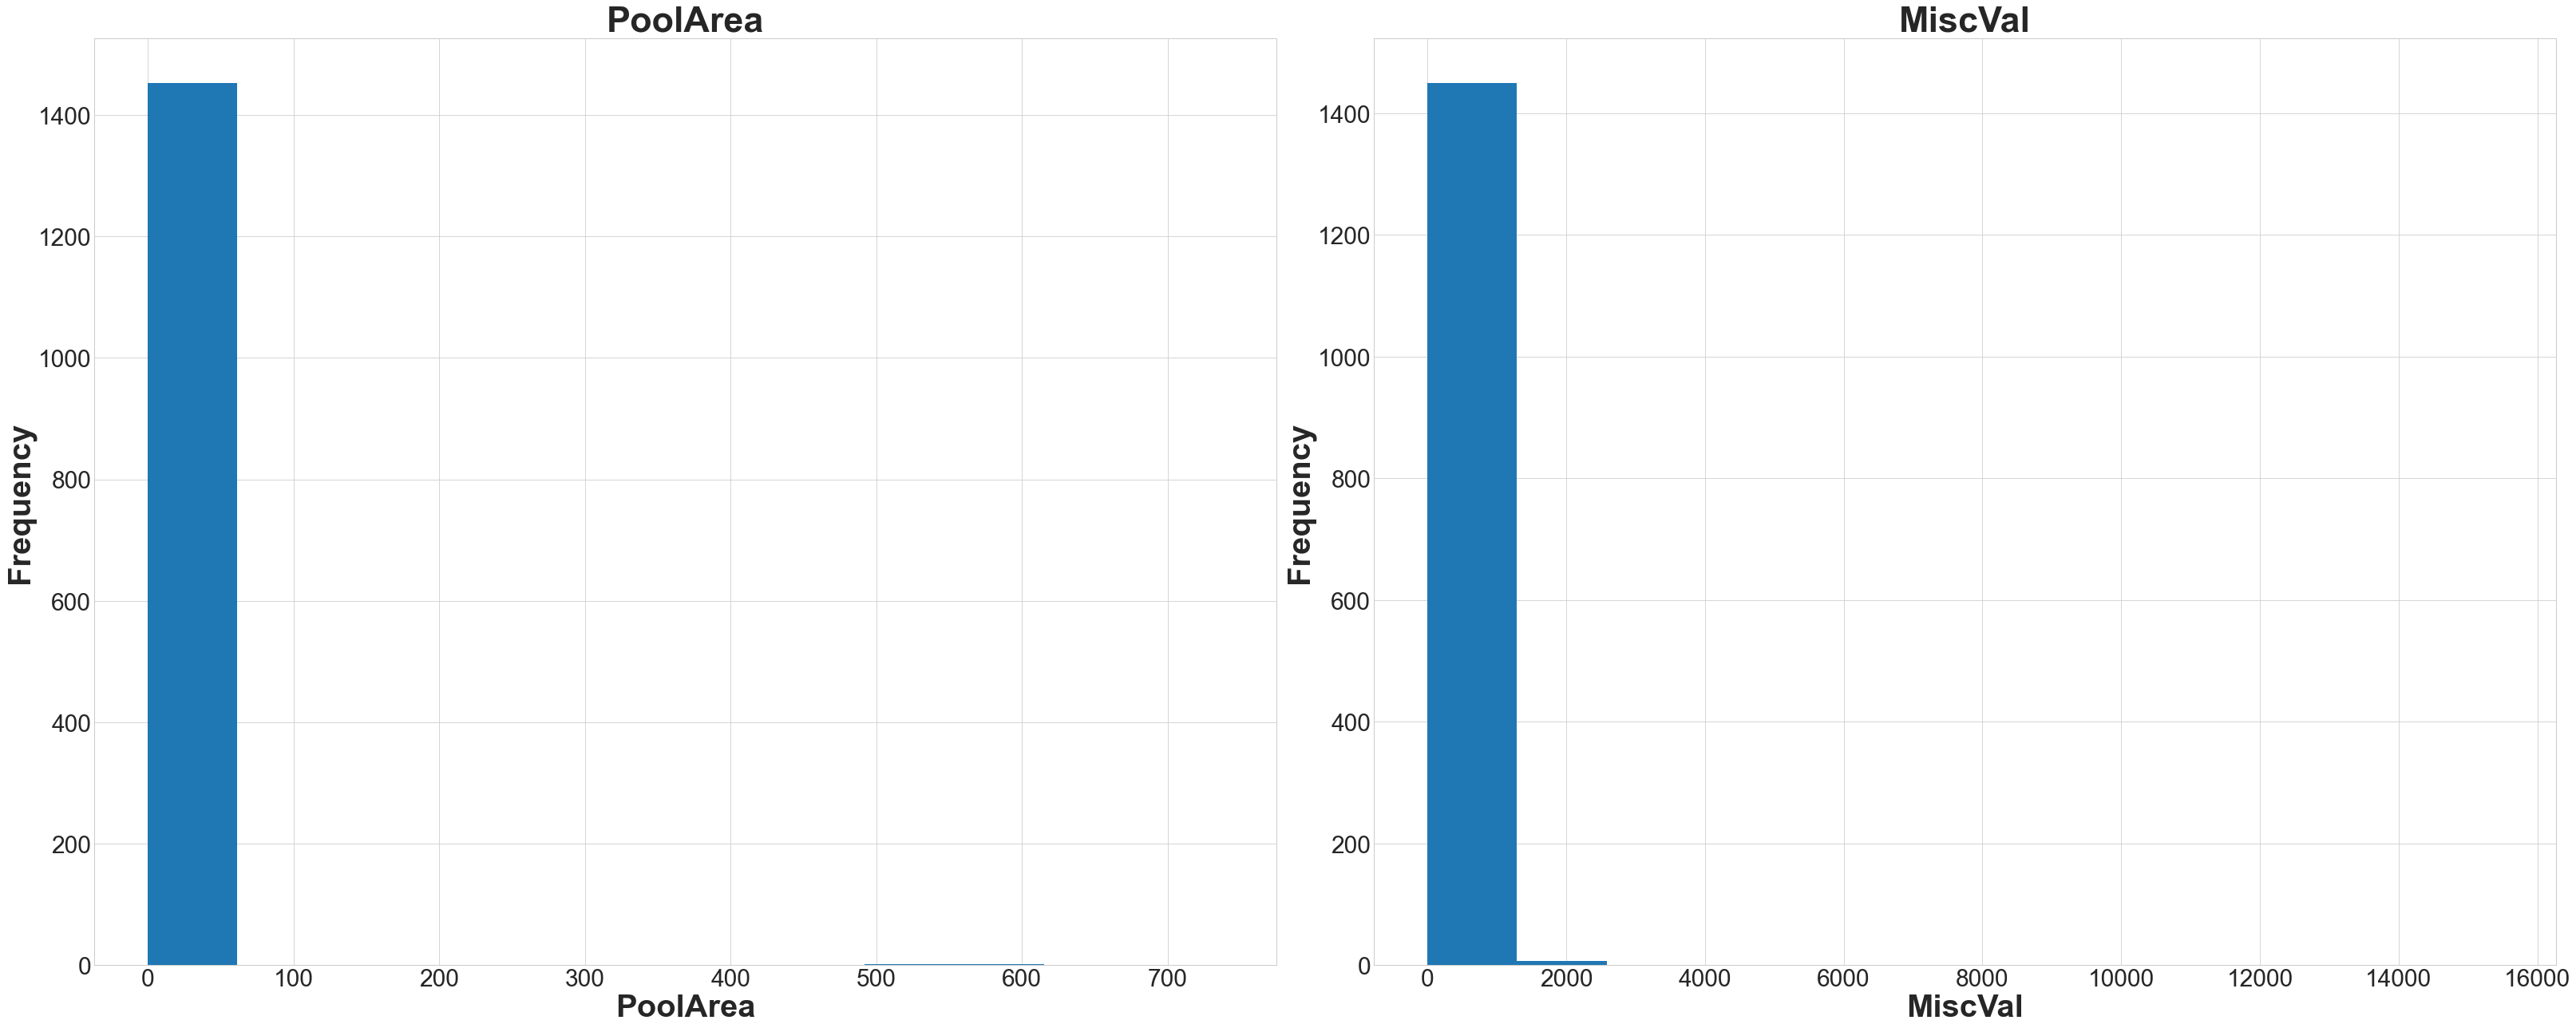

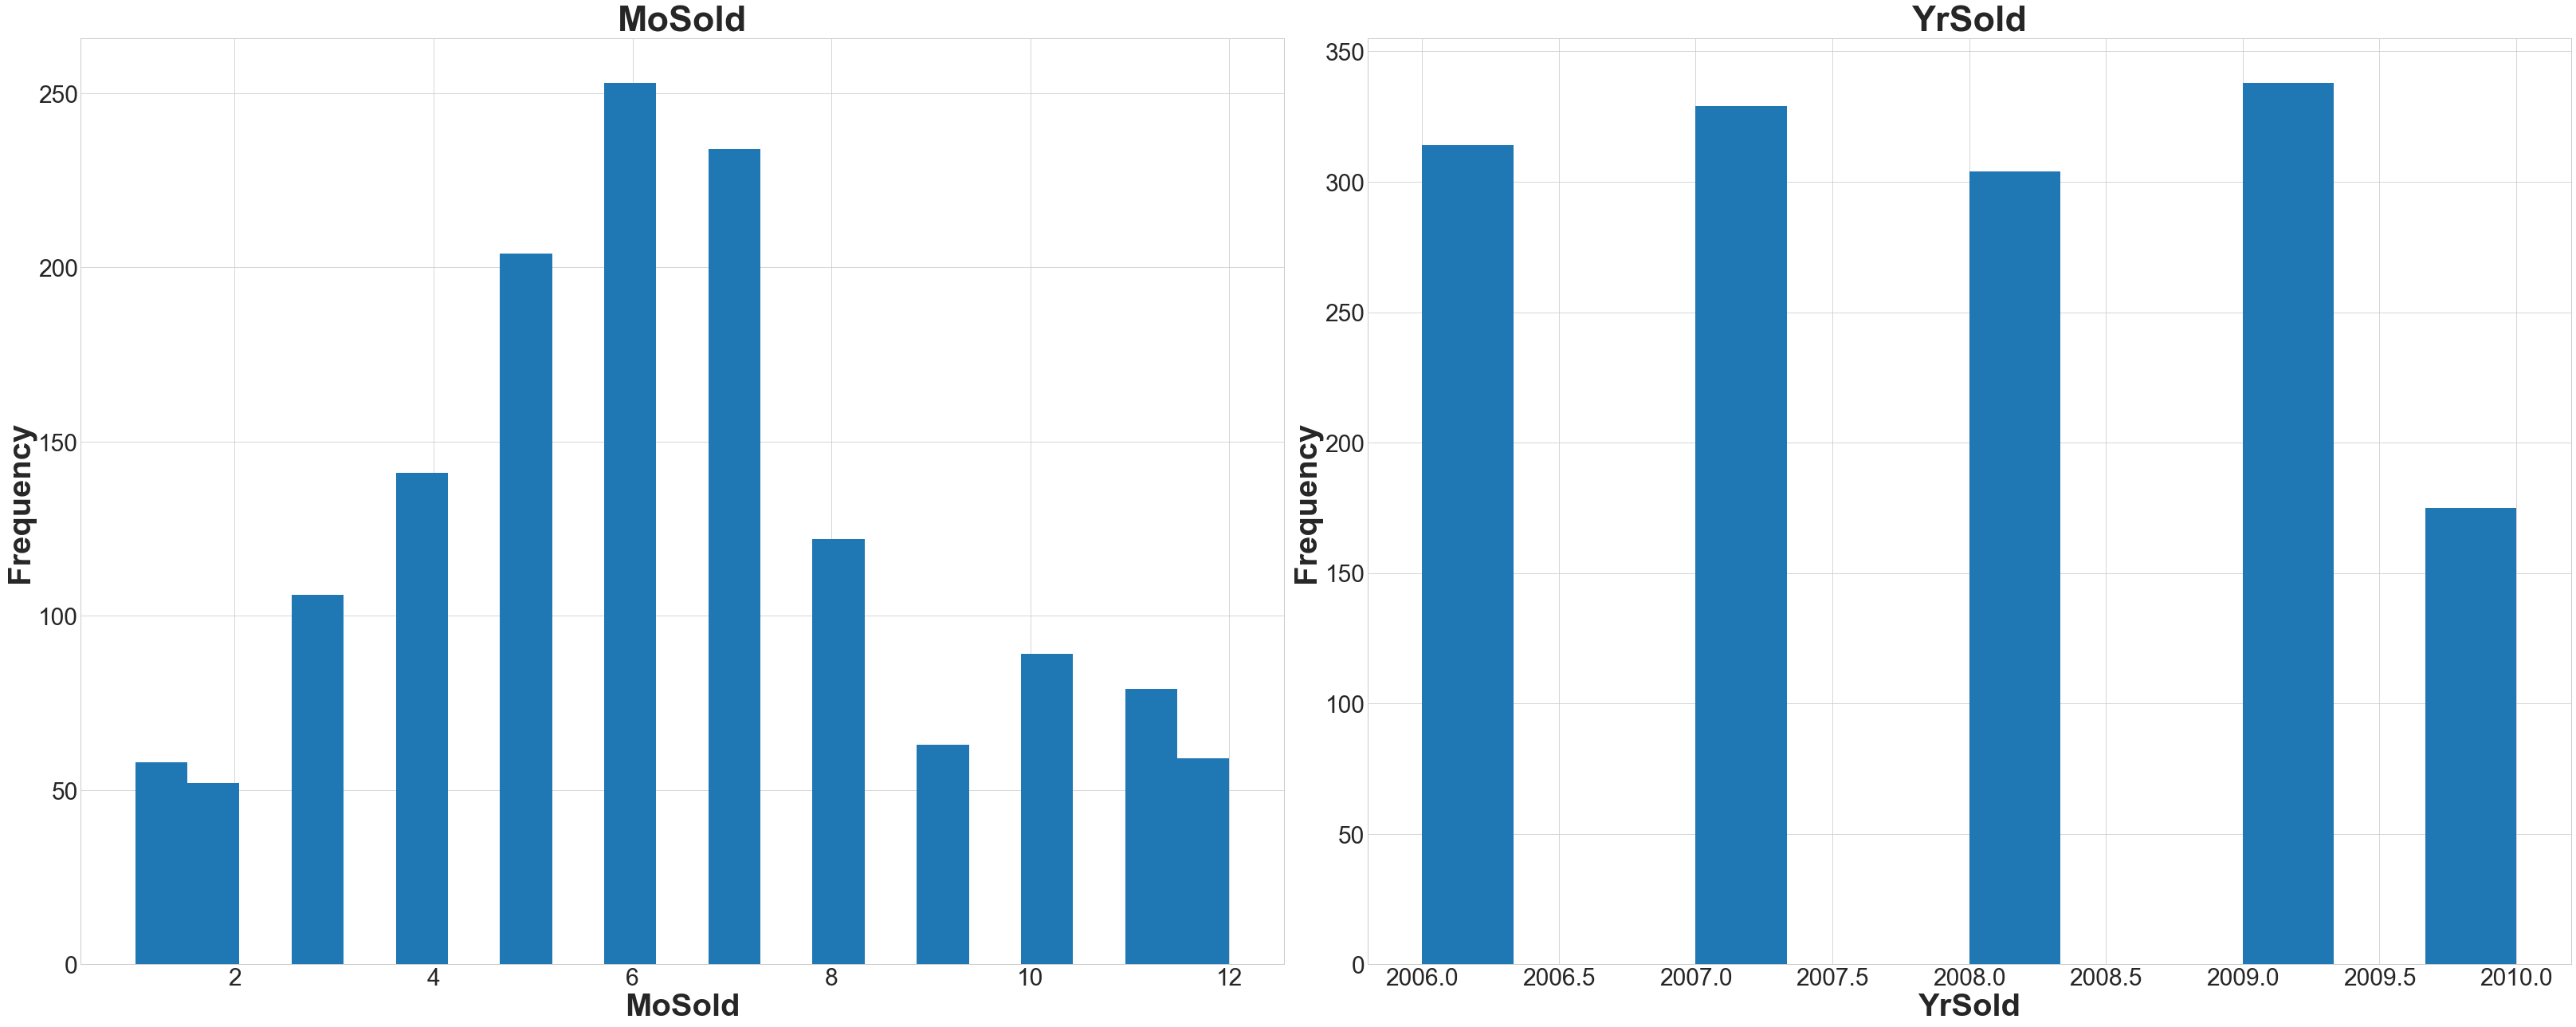

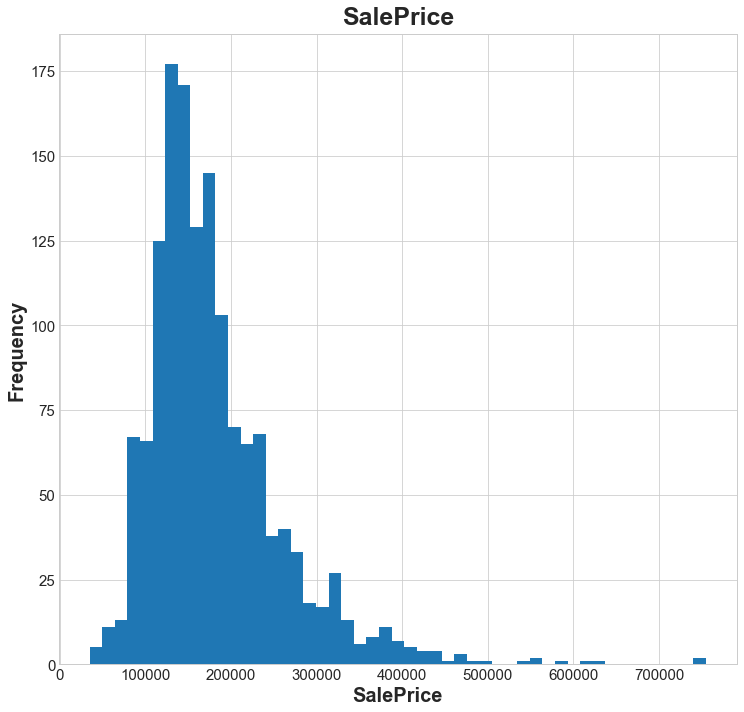

In [10]:
'''
These columns have IQR equal to zero. Freedman Diaconis Rule doesn't work significantly well for these columns. 
Use sturges rule to find the optimal number of bins for the columns.
'''
cols_list = ['LowQualFinSF','BsmtFinSF2','BsmtHalfBath','KitchenAbvGr',
             'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

# Except ID
hist_cols = numeric_cols[1:]

for i in range(0,len(hist_cols),2):
    if(i == len(hist_cols)-1):
        plot_histogram(train,hist_cols[i],hist_cols[i],cols_list,True)
    else:
        plot_histogram(train,hist_cols[i],hist_cols[i+1],cols_list)

## Data Transformation

#### Skewed data

In [11]:
def find_skewness(train, numeric_cols):
    
    """
    Calculate the skewness of the columns and segregate the positive
    and negative skewed data.
    """
    
    skew_dict = {}
    
    for col in numeric_cols:
        skew_dict[col] = train[col].skew()

    skew_dict = dict(sorted(skew_dict.items(),key=itemgetter(1)))
    positive_skew_dict = {k:v for (k,v) in skew_dict.items() if v>0}
    negative_skew_dict = {k:v for (k,v) in skew_dict.items() if v<0}
    return skew_dict, positive_skew_dict, negative_skew_dict

def add_constant(data, highly_pos_skewed):
    
    """
    Look for zeros in the columns. If zeros are present then the log(0) would result in -infinity.
    So before transforming it we need to add it with some constant.
    """
    
    C = 1
    for col in highly_pos_skewed.keys():
        if(col != 'SalePrice'):
            if(len(data[data[col] == 0]) > 0):
                data[col] = data[col] + C
    return data

def log_transform(data, highly_pos_skewed):
    
    """
    Log transformation of highly positively skewed columns.
    """
    
    for col in highly_pos_skewed.keys():
        if(col != 'SalePrice'):
            data[col] = np.log10(data[col])
    return data

def sqrt_transform(data, moderately_pos_skewed):
    
    """
    Square root transformation of moderately skewed columns.
    """
    
    for col in moderately_pos_skewed.keys():
        if(col != 'SalePrice'):
            data[col] = np.sqrt(data[col])
    return data

def reflect_sqrt_transform(data, moderately_neg_skewed):
    
    """
    Reflection and log transformation of highly negatively skewed 
    columns.
    """
    
    for col in moderately_neg_skewed.keys():
        if(col != 'SalePrice'):
            K = max(data[col]) + 1
            data[col] = np.sqrt(K - data[col])
    return data

In [12]:
"""
If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
"""
skew_dict, positive_skew_dict, negative_skew_dict = find_skewness(train, numeric_cols)
moderately_pos_skewed = {k:v for (k,v) in positive_skew_dict.items() if v>0.5 and v<=1}
highly_pos_skewed = {k:v for (k,v) in positive_skew_dict.items() if v>1}
moderately_neg_skewed = {k:v for (k,v) in negative_skew_dict.items() if v>-1 and v<=0.5}
highly_neg_skewed = {k:v for (k,v) in negative_skew_dict.items() if v<-1}

'''Transform train data.'''

train = add_constant(train, highly_pos_skewed)
train = log_transform(train, highly_pos_skewed)
train = sqrt_transform(train, moderately_pos_skewed)
train = reflect_sqrt_transform(train, moderately_neg_skewed )

'''Transform test data.'''

test = add_constant(test, highly_pos_skewed)
test = log_transform(test, highly_pos_skewed)
test = sqrt_transform(test, moderately_pos_skewed)
test = reflect_sqrt_transform(test, moderately_neg_skewed )

#### Categorical Encoding

##### Ordinal Encoding

In [13]:
ordinal_col_dicts = {
    'ExterQual':{'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'ExterCond': {'TA': 3, 'Gd': 2, 'Fa': 4, 'Ex': 1, 'Po': 5},
    'BsmtQual': {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'BsmtCond': {'Fa': 4, 'Gd': 2, 'Po': 5, 'TA': 3,'Ex':1, 'NA':6},
    'BsmtExposure': {'No': 4, 'Av': 2, 'Gd': 1, 'Mn': 3,'NA':5},
    'BsmtFinType1': {'Unf': 6, 'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'NA':7},
    'BsmtFinType2': {'Unf': 6, 'Rec': 4, 'LwQ': 5, 'BLQ': 3, 'ALQ': 2, 'GLQ': 1, 'NA':7},
    'HeatingQC': {'Ex': 1, 'TA': 3, 'Gd': 2, 'Fa': 4, 'Po': 5},
    'CentralAir': {'Y': 1, 'N': 2},
    'Electrical': {'SBrkr': 1, 'FuseA': 2, 'FuseF': 3, 'FuseP': 4, 'Mix': 5},
    'KitchenQual': {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'Functional': {'Typ': 1, 'Min2': 3, 'Min1': 2, 'Mod': 4, 'Maj1': 5, 'Maj2': 6, 'Sev': 7, 'Sal':8},
    'FireplaceQu': {'Gd': 2, 'TA': 3, 'Fa': 4, 'Ex': 1, 'Po': 5},
    'GarageFinish': {'Unf': 3, 'RFn': 2, 'Fin': 1, 'NA':4},
    'GarageQual': {'TA': 3, 'Fa': 4, 'Gd': 2, 'Ex': 1, 'Po': 5},
    'GarageCond': {'TA': 3, 'Fa': 4, 'Gd': 2, 'Po': 5, 'Ex': 1},
    'PavedDrive': {'Y': 1, 'N': 3, 'P': 2},
    'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
    'Utilities': {'AllPub': 1, 'NoSeWa': 3, 'NoSewr':2, 'ELO':4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'BldgType': {'1Fam': 1, 'TwnhsE': 4, 'Duplex': 3, 'Twnhs': 5, '2fmCon': 2},
    'HouseStyle': {'1Story': 1,  '2Story': 4, '1.5Fin': 2, 'SLvl': 8, 'SFoyer': 7, '1.5Unf': 3, '2.5Unf': 6, '2.5Fin': 5},
    'LotConfig': {'Inside': 1, 'Corner': 2, 'CulDSac': 3, 'FR2': 4, 'FR3': 5}
}

def ordinal_encode(data, ordinal_col_dicts): 
    
    """
    Ordinal encode the ordinal columns according to the values in 
    ordinal_col_dicts.
    """
    
    for ord_col in ordinal_col_dicts:
        ord_dict = ordinal_col_dicts[ord_col]
        data[ord_col] = data[ord_col].map(ord_dict)
    return data

train = ordinal_encode(train, ordinal_col_dicts)
test = ordinal_encode(test, ordinal_col_dicts)

##### Nominal Encoding

In [14]:
def target_encode(train, test):
    
    """
    Target encoding uses the mean of the target to encode
    categorical data.
    """
    
    target_enc = TargetEncoder()
    x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
    x_train = target_enc.fit_transform(x_train,y_train)
    test = target_enc.transform(test)
    train = pd.concat([x_train, y_train], axis = 1)
    return train, test

train, test = target_encode(train, test)

##### Normalization

In [15]:
def standard_scale(train,test):  
    """
    Built - in function to normalize data.
    """
    
    ss = StandardScaler()
    x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
    x_train = pd.DataFrame(ss.fit_transform(x_train),columns = x_train.columns,index = x_train.index)
    test = pd.DataFrame(ss.transform(test),columns = test.columns,index = test.index)
    return x_train, y_train, test

x_train, y_train, test = standard_scale(train, test)

## Data Modeling

In [16]:
def fit_model(x_train,y_train, model):
    
    """
    Fits x_train to y_train for the given
    model.
    """
    model.fit(x_train,y_train)
    return model

'''Xtreme Gradient Boosting Regressor'''

model = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
model = fit_model(x_train,y_train, model)

'''Predict the outcomes'''
predictions = model.predict(test)

In [17]:
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = predictions
submission.to_csv('submission.csv',index=False)

In [18]:
submission

,Id,SalePrice
0,1461,121603.054688
1,1462,161330.765625
2,1463,186631.140625
3,1464,197599.328125
4,1465,196316.281250
...,...,...
1454,2915,78638.578125
1455,2916,88111.023438
1456,2917,173103.390625
1457,2918,101068.179688


## Load Data

In [19]:
def load_data():
    # Read data
    data_dir = Path(".\house-prices-advanced-regression-techniques")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [20]:
data_dir = Path(".\house-prices-advanced-regression-techniques")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [21]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

##### Encode the Statistical Data Type

In [22]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

##### Handle Missing Values

In [23]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [24]:
df_train, df_test = load_data()

## Establish Baseline

In [25]:
def score_dataset(X, y, model=XGBRegressor()):
    
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring="neg_mean_squared_error",)
    score = -1 * score.mean()
    score = np.sqrt(score)
    
    return score

In [26]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


## Feature Utility Scores

In [27]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [28]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

In [32]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [33]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.14338026718687277

## Create Features

In [34]:
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X

In [35]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

### Creaye Features with Pandas

In [36]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

### k-Means Clustering

In [37]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [38]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

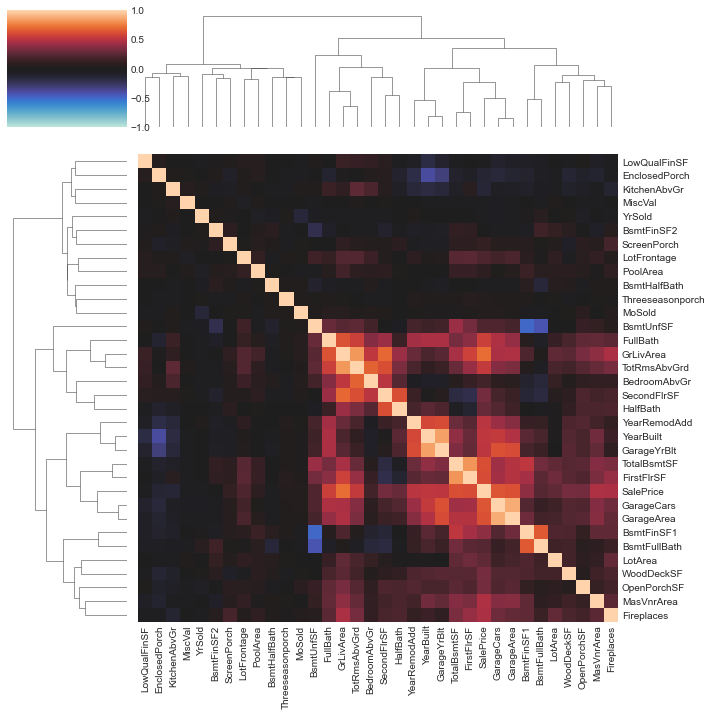

In [39]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)


#### PCA Application - Indicate Outliers

In [40]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

### Target Encoding

In [41]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        return X_encoded

In [42]:
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"])

### Create Final Feature Set

In [43]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.1381925629969659

## Hyperparameter Tuning

In [44]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12435395194830864

In [45]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2022-08-25 20:23:03,754] A new study created in memory with name: no-name-30c0d63e-cd19-4deb-89e0-9cfcb739c2f5
[I 2022-08-25 20:23:28,374] Trial 0 finished with value: 0.48622095839856044 and parameters: {'max_depth': 3, 'learning_rate': 0.0005112795139046516, 'n_estimators': 6277, 'min_child_weight': 10, 'colsample_bytree': 0.4440224856095263, 'subsample': 0.8983274636768657, 'reg_alpha': 0.10819591915885142, 'reg_lambda': 0.00018730874505951792}. Best is trial 0 with value: 0.48622095839856044.
[I 2022-08-25 20:23:47,268] Trial 1 finished with value: 0.31382604977814005 and parameters: {'max_depth': 5, 'learning_rate': 0.0007854271391669245, 'n_estimators': 4851, 'min_child_weight': 8, 'colsample_bytree': 0.7060912744716406, 'subsample': 0.6011582913946938, 'reg_alpha': 0.45319205601404405, 'reg_lambda': 2.1985041071660096}. Best is trial 1 with value: 0.31382604977814005.
[I 2022-08-25 20:24:13,578] Trial 2 finished with value: 0.12593292543385382 and parameters: {'max_depth': 8,

## Train Model and Create Submissions

In [46]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('house_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
